# 1. Классический скоринг

In [ ]:
!pip install autowoe -q
!pip install lightgbm==4.5.0  -q
!pip install catboost -q
!pip install pandas==2.2.2  -q
!pip install shap==0.46.0  -q
!pip install crosspredict==1.1.11 --no-deps  -q
!pip install dask[dataframe] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import yaml
import warnings
from autowoe import AutoWoE, ReportDeco
from collections import defaultdict
from crosspredict.report_binary import ReportBinary
from crosspredict.nodes import model_fit, forward_selection, hyperopt_fit, onefactor, model_single_fit
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget https://raw.githubusercontent.com/senior-sigan/Tinkoff-Data-Science-Challenge/master/task1/data/credit_train.csv.zip

--2025-02-18 09:19:45--  https://raw.githubusercontent.com/senior-sigan/Tinkoff-Data-Science-Challenge/master/task1/data/credit_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3276871 (3.1M) [application/zip]
Saving to: ‘credit_train.csv.zip’

credit_train.csv.zi 100%[===================>]   3.12M  --.-KB/s    in 0.05s   

2025-02-18 09:19:46 (57.9 MB/s) - ‘credit_train.csv.zip’ saved [3276871/3276871]



In [ ]:
df = pd.read_csv('credit_train.csv.zip', encoding='cp1251', delimiter=';', index_col='client_id')
import datetime
X = pd.date_range(datetime.date(2022,1,1),datetime.date(2023,1,1)).tolist()*int(170746/366)+pd.date_range(datetime.date(2022,1,1),datetime.date(2023,1,1),190).tolist()
X = [x.date() for x in X]
df['SIGN_DATE'] = X
df['SIGN_DATE_mon'] = df['SIGN_DATE'].map(lambda x: x.replace(day=1))
df['credit_sum'] = df['credit_sum'].str.replace(',','.')
df['credit_sum'] = pd.to_numeric(df['credit_sum'])
df['score_shk'] = df['score_shk'].str.replace(',','.')
df['score_shk'] = pd.to_numeric(df['score_shk'])

In [ ]:
params = '''
lgb_params:
  bagging_fraction: 0.849285747554019
  bagging_freq: 5
  bagging_seed: 0
  boosting_type: 'gbdt'
  data_random_seed: 0
  drop_seed: 0
  feature_fraction: 0.8212766928844304
  feature_fraction_seed: 0
  lambda_l1: 0.8955546599539566
  lambda_l2: 1.4423261095989717
  learning_rate: 0.03
  max_bin: 255
  max_depth': 43
  metric: 'auc'
  min_data_in_leaf: 149
  min_sum_hessian_in_leaf: 1.804477623298885
  num_leaves: 363
  objective: 'binary'
  seed: 0
  verbose: -1
n_repeats: 2
n_splits: 5
num_boost: 9999
early_stopping: 50
col_target: 'open_account_flg'
col_client: 'id_client'
cv_byclient: False
cols_exclude: ['predict_stacking','predict_boosting','SIGN_DATE_mon','SIGN_DATE','open_account_flg','target_adversarial','predict']
cols_cat: ['tariff_id', 'gender','marital_status','job_position','living_region','education']

adversarial_frac: 0.25
col_date: 'SIGN_DATE'
col_date_mon: 'SIGN_DATE_mon'
col_adversarial: 'target_adversarial'

hyperopt_trials: 3
'''
with open('params.yaml','w') as f:
    f.write(params)

In [ ]:
with open('params.yaml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

### Autowoe

In [ ]:
cat_feature_list = params['cols_cat']
num_feature_list = list(set(df.columns)-set(params['cols_cat'])-set([params['col_target']]))

In [ ]:

auto_woe = AutoWoE(
    interpreted_model=True,
    monotonic=True,
    max_bin_count=10,
    select_type=50,
    pearson_th=0.9,
    auc_th=.505,
    vif_th=10.,
    imp_th=0,
    th_const=32,
    force_single_split=True,
    th_nan=0.01,
    th_cat=0.005,
    woe_diff_th=0.01,
    min_bin_size=0.01,
    min_bin_mults=(2, 4),
    min_gains_to_split=(0.0, 0.5, 1.0),
    auc_tol=1e-3,
    cat_alpha=100,
    cat_merge_to="to_woe_0",
    nan_merge_to="to_woe_0",
    oof_woe=True,
    n_folds=5,
    n_jobs=8,
    l1_grid_size=20,
    l1_exp_scale=6,
    imp_type="feature_imp",
    regularized_refit=True,
    p_val=0.05,
    debug=False,
    verbose=0
)

auto_woe = ReportDeco(auto_woe)
cat_feature_type = {x: 'cat' for x in cat_feature_list }
num_feature_type = {x: 'real' for x in num_feature_list}
feature_list = num_feature_list + cat_feature_list

features_type = dict(**num_feature_type, **cat_feature_type)

auto_woe.fit(
    df[feature_list + [params['col_target']]].sample(n=10000),
    target_name=params['col_target'],
    features_type=features_type,
    group_kf=None,
)

df['predict'] = auto_woe.predict_proba(df)



[LightGBM] [Info] Number of positive: 1377, number of negative: 6623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172125 -> initscore=-1.570641
[LightGBM] [Info] Start training from score -1.570641
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	val_test's auc: 0.756382


In [ ]:
print(auto_woe.get_sql_inference_query('name_table'))


SELECT
  1 / (1 + EXP(-(
    -1.56
    -1.141*WOE_TAB.tariff_id
    -0.77*WOE_TAB.living_region
    -1.025*WOE_TAB.credit_sum
    -0.421*WOE_TAB.credit_count
    -1.477*WOE_TAB.credit_month
    -0.462*WOE_TAB.education
    -0.427*WOE_TAB.overdue_credit_count
    -0.552*WOE_TAB.marital_status
    -0.609*WOE_TAB.score_shk
    -0.558*WOE_TAB.age
    -0.83*WOE_TAB.job_position
    -0.831*WOE_TAB.gender
  ))) as PROB,
  WOE_TAB.*
FROM 
    (SELECT
    CASE
      WHEN (tariff_id IS NULL OR LOWER(CAST(tariff_id AS VARCHAR(50))) = 'nan') THEN 0
      WHEN tariff_id IN (1.0, 1.16) THEN 0.682
      WHEN tariff_id == 1.1 THEN -0.13
      WHEN tariff_id == 1.3 THEN -0.604
      WHEN tariff_id == 1.32 THEN -1.031
      WHEN tariff_id IN (1.4, 1.5) THEN 0.808
      WHEN tariff_id == 1.9 THEN 1.382
      ELSE 0.287
    END AS tariff_id,
    CASE
      WHEN (living_region IS NULL OR LOWER(CAST(living_region AS VARCHAR(50))) = 'nan') THEN 0
      WHEN living_region == 'КРАЙ СТАВРОПОЛЬСКИЙ' THEN 2.262
 

In [ ]:
report_params = {"automl_date_column": params['col_date_mon'],
                 "output_path": "report/",
                 "report_name": "white box",
                 "report_version_id": 1,
                 "city": "Moscow",
                 "model_aim": "application default",
                 "model_name": "application default",
                 "zakazchik": "-",
                 "high_level_department": "DS",
                 "ds_name": "-",
                 "target_descr": "default",
                 "non_target_descr": "not default"}

auto_woe.generate_report(report_params)

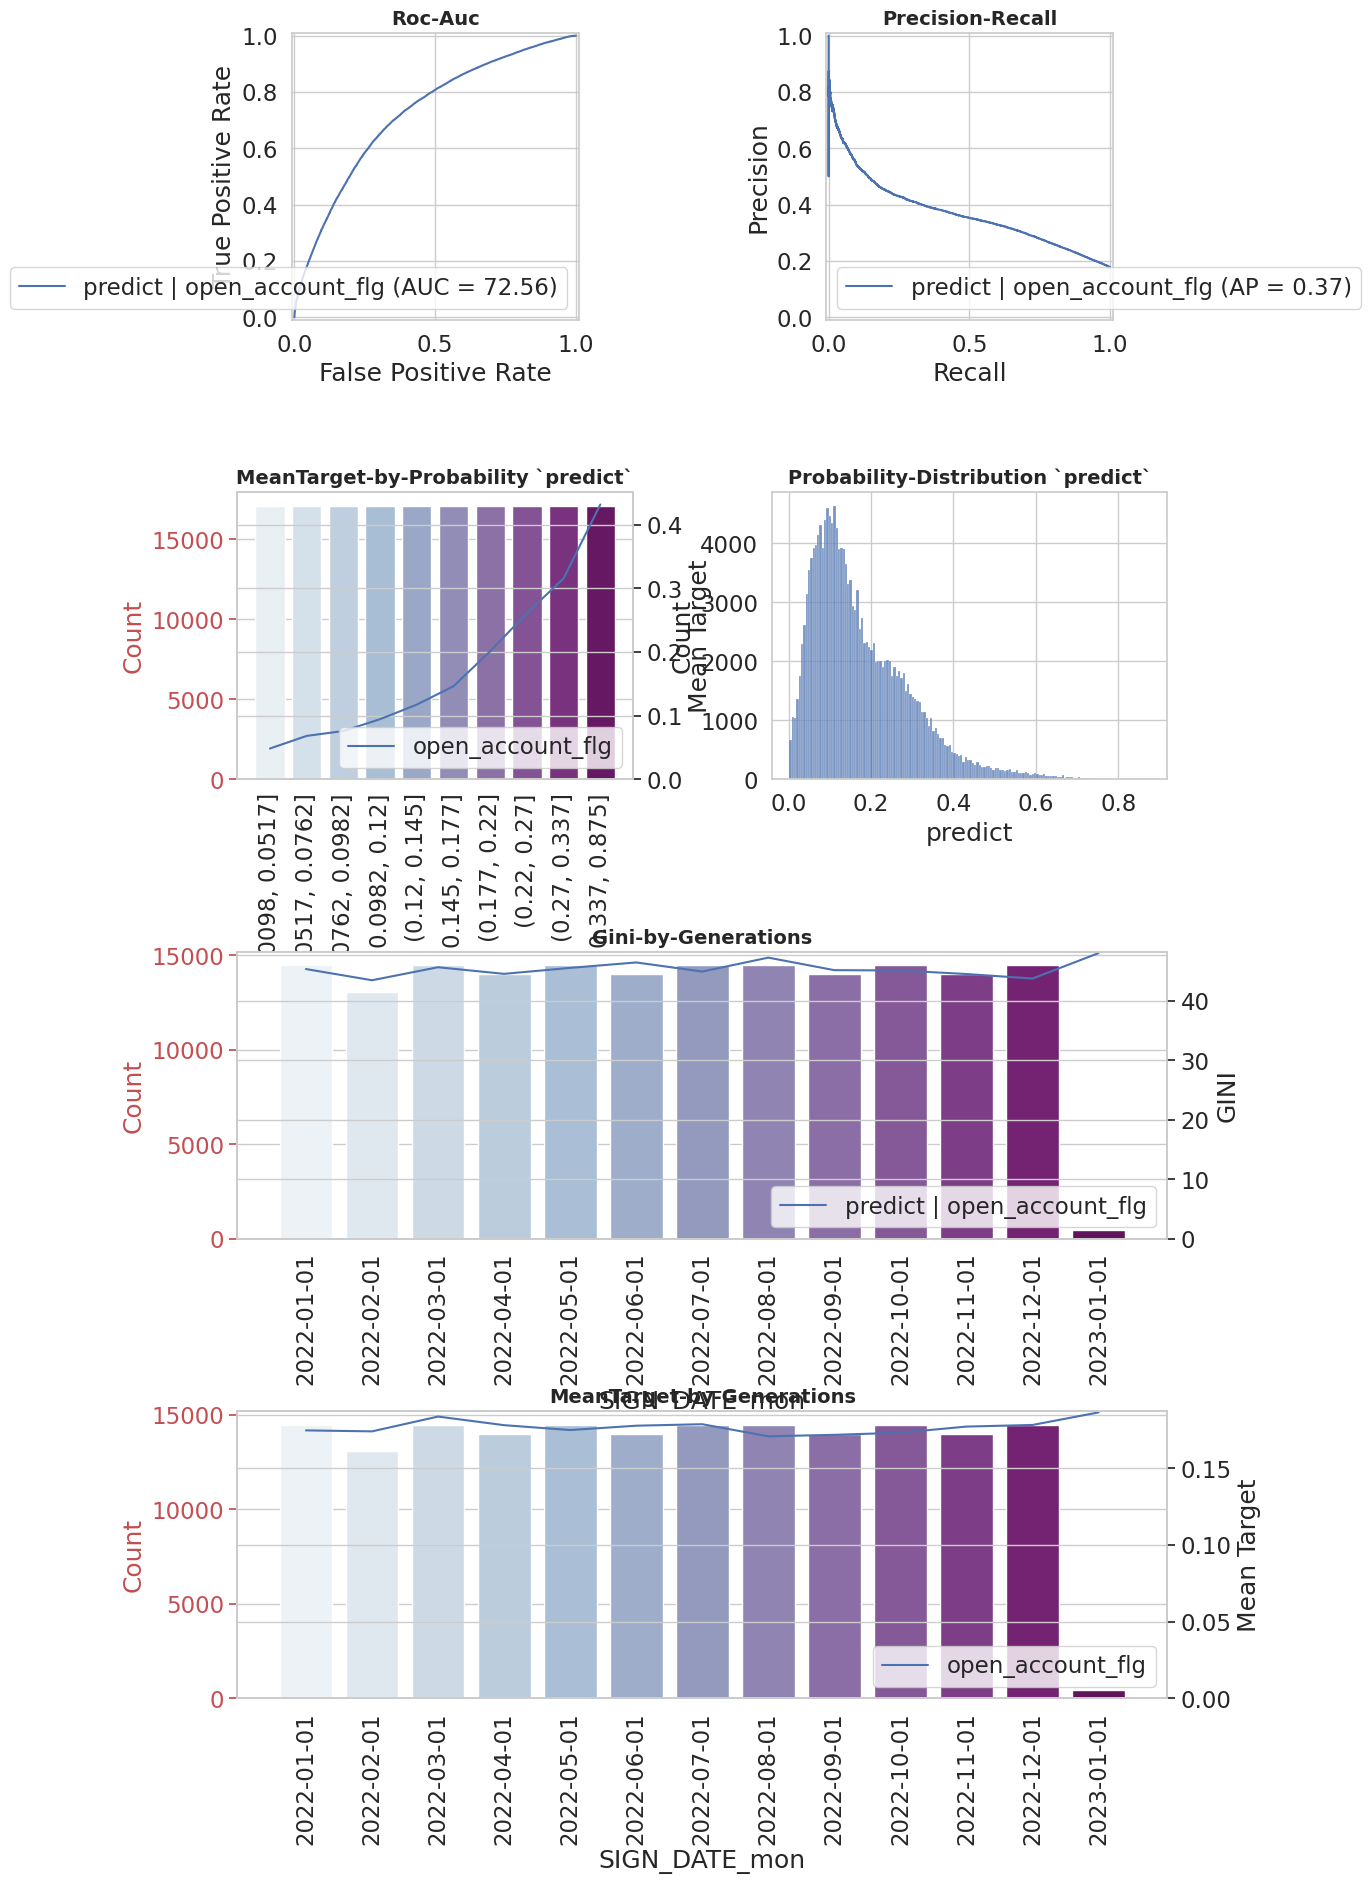

In [ ]:
a = ReportBinary()
a.plot_report(
    df,
    report_shape = (5,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(1, 0)}],
          'Gini-by-Generations': {'loc':(2,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(3,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(1,1)}]
            },
    cols_score = ['predict'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

## Gini for features

In [ ]:
def categorizer(df, col):
  X = df[col].value_counts()
  X = X[X>100]
  mapping = {j:i+2 for i,j in enumerate(X.index)}

  d = defaultdict(lambda: 1)
  d.update(mapping)
  return d

mapping = {}

for col in params['cols_cat']:
  mapping1 = categorizer(df, col)
  df[col] = df[col].map(mapping1)
  mapping.update({col:mapping1})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def abs_gini(roc_auc):
  return abs(2 * roc_auc - 1)
df.fillna(0, inplace = True)
cols_to_check = ['age', 'credit_sum',
       'credit_month', 'score_shk',
       'monthly_income', 'credit_count', 'overdue_credit_count']

def plot_gini_feature(df, params, col):
  mon_array = sorted(df[params['col_date_mon']].unique())
  col_gini = np.zeros(len(mon_array))
  for idx, mon in enumerate(mon_array):
    df_small = df[df[params['col_date_mon']] <= mon]
    col_gini[idx] = abs_gini(roc_auc_score(df_small[params['col_target']] , df_small[col]))
  plt.scatter(x = mon_array, y = col_gini)
  plt.gca().tick_params(axis='x', rotation=45)
  plt.ylim(0, 0.25)
  plt.gca().set_title(label = col)
  plt.show()

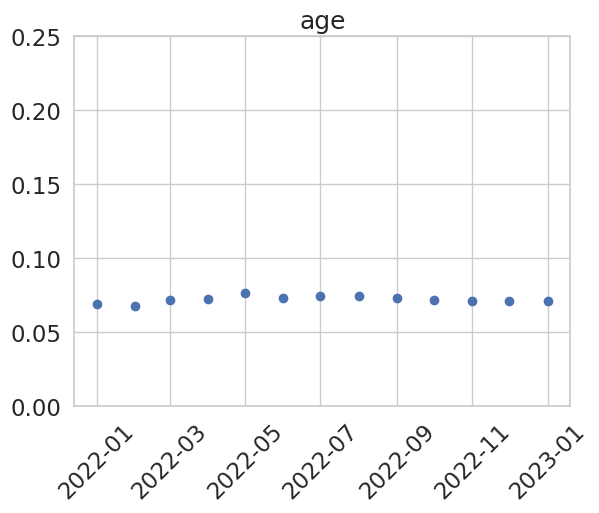

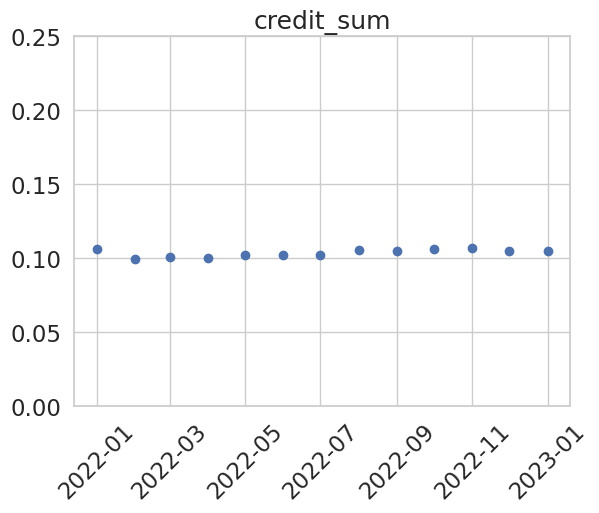

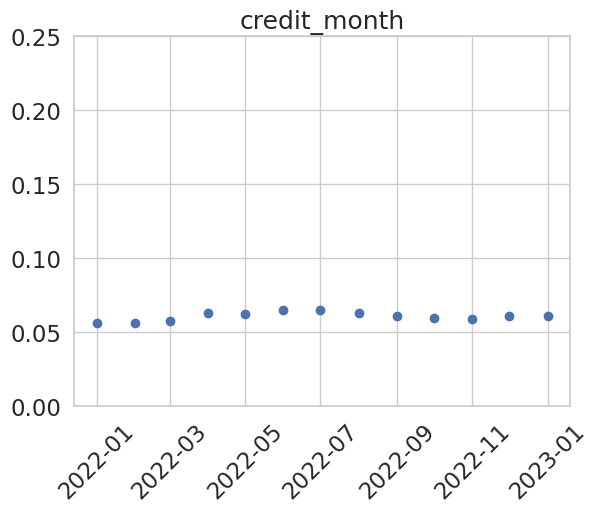

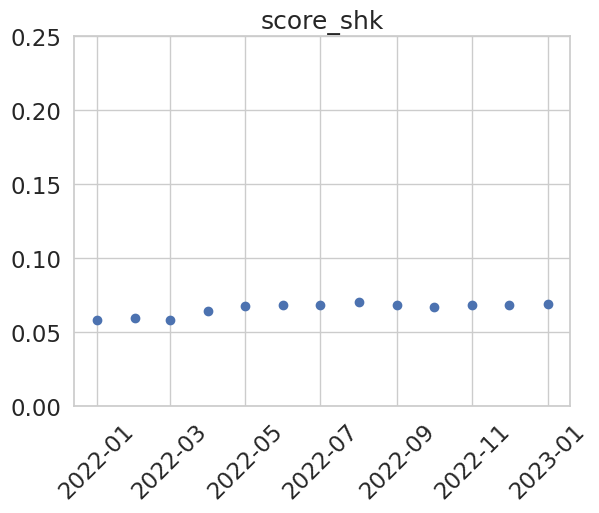

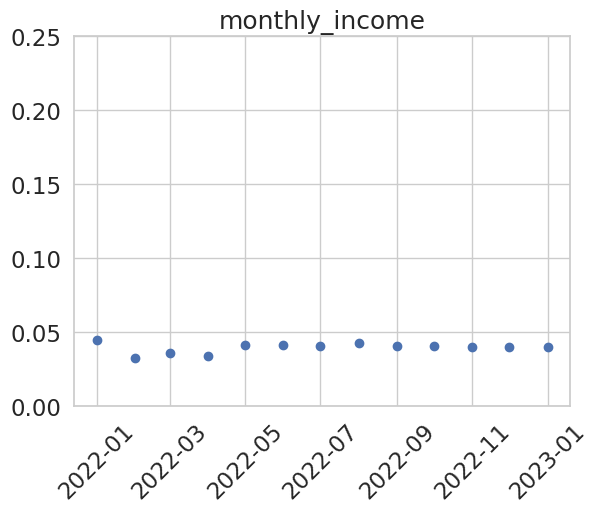

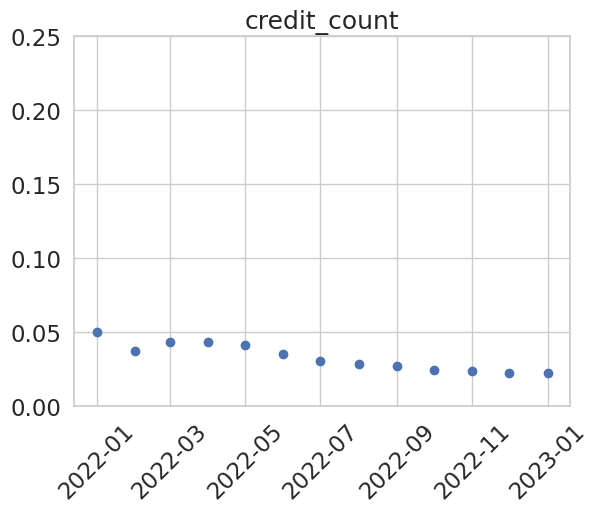

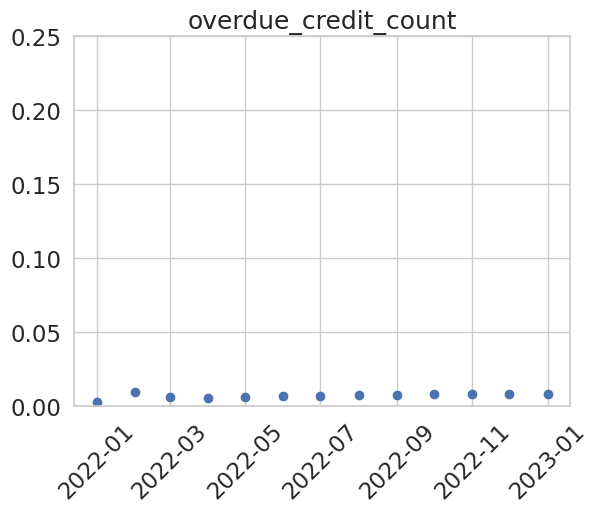

In [ ]:
for col in cols_to_check:
  plot_gini_feature(df, params, col)

## GINI for features v2

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def abs_gini(roc_auc):
  return abs(2 * roc_auc - 1)
df.fillna(0, inplace = True)
cols_to_check = ['age', 'credit_sum',
       'credit_month', 'score_shk',
       'monthly_income', 'credit_count', 'overdue_credit_count']

def plot_gini_feature(df, params, col):
  mon_array = sorted(df[params['col_date_mon']].unique())
  col_gini = np.zeros(len(mon_array))
  for idx, mon in enumerate(mon_array):
    df_small = df[df[params['col_date_mon']] == mon]
    col_gini[idx] = abs_gini(roc_auc_score(df_small[params['col_target']] , df_small[col]))
  plt.scatter(x = mon_array, y = col_gini)
  plt.gca().tick_params(axis='x', rotation=45)
  plt.ylim(0, 0.25)
  plt.gca().set_title(label = col)
  plt.show()

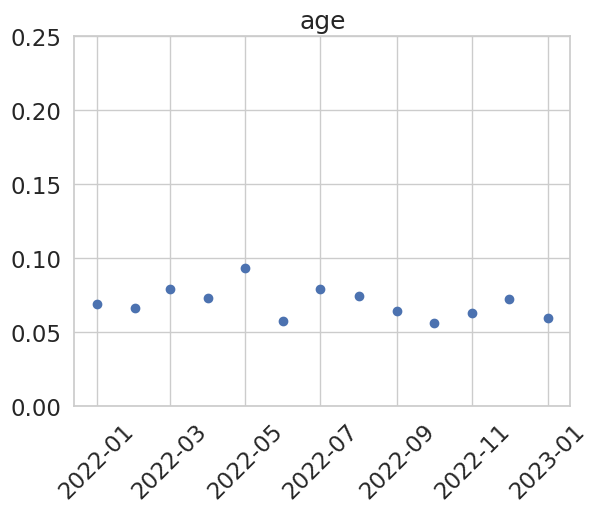

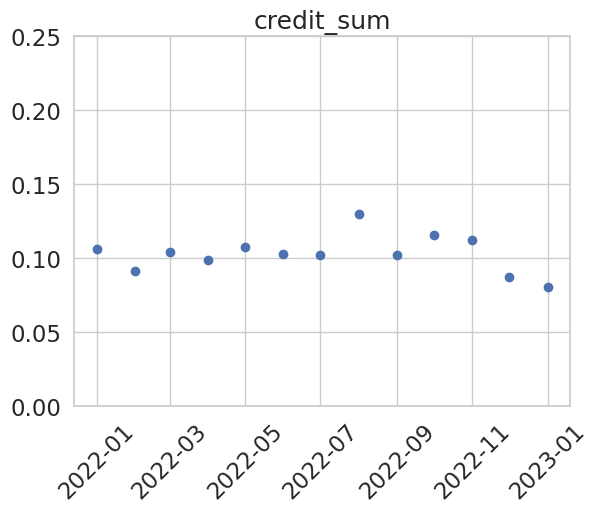

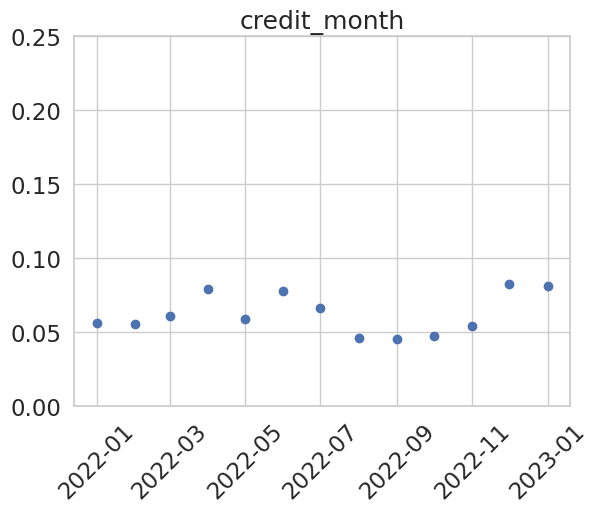

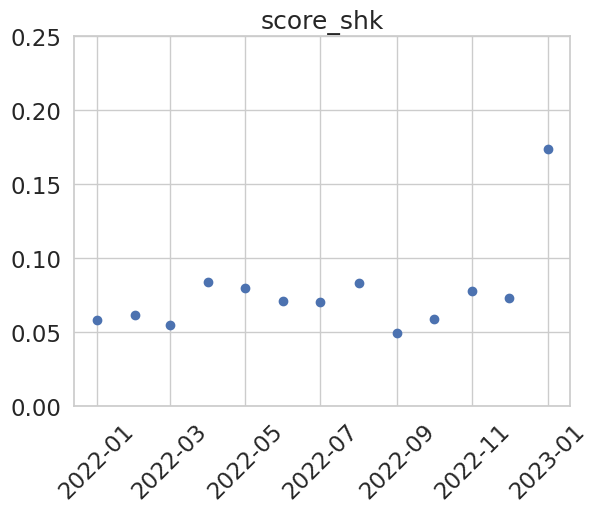

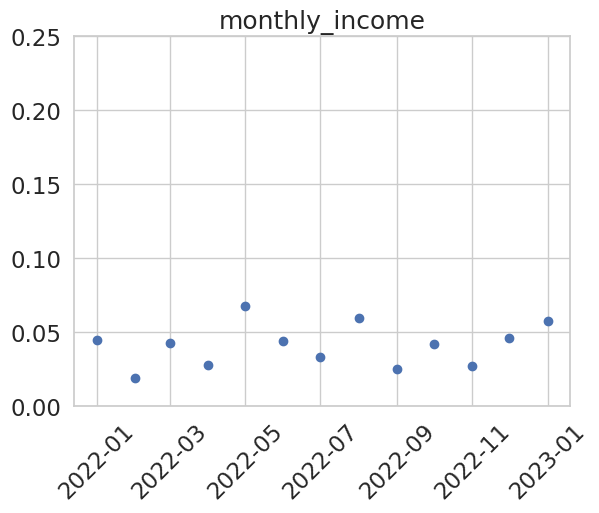

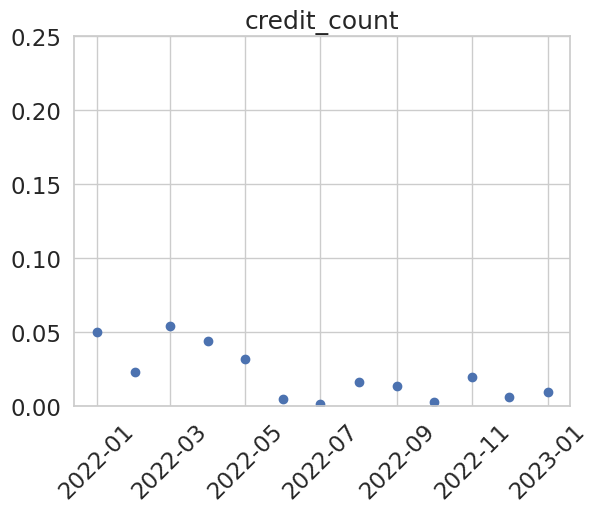

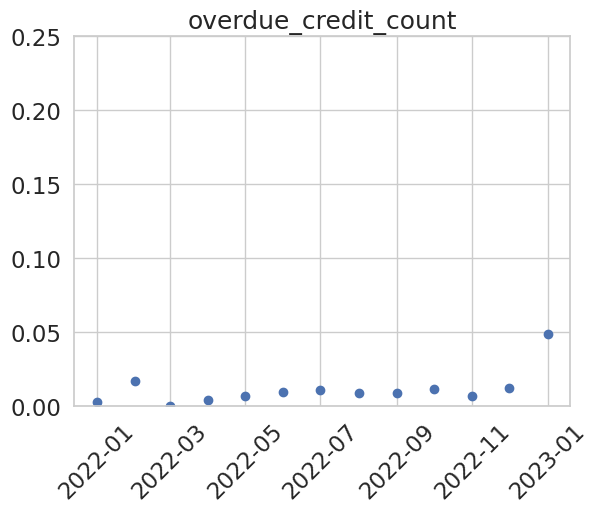

In [ ]:
for col in cols_to_check:
  plot_gini_feature(df, params, col)

### Boosting

In [ ]:
test = df[df[params['col_date']]>=datetime.date(2022,8,1)].copy()
train = df[df[params['col_date']]<datetime.date(2022,8,1)].copy()

#### Adversarial

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.759402	eval's auc: 0.50045
Early stopping, best iteration is:
[2]	train's auc: 0.601393	eval's auc: 0.501142
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.764365	eval's auc: 0.500064
Early stopping, best iteration is:
[2]	train's auc: 0.599319	eval's auc: 0.504553
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.761569	eval's auc: 0.500046
[100]	train's auc: 0.814937	eval's auc: 0.500122
Early stopping, best iteration is:
[98]	train's auc: 0.813759	eval's auc: 0.500666
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.759915	eval's auc: 0.502555
Early stopping, best iteration is:
[35]	train's auc: 0.737146	eval's auc: 0.503754
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.76063	eval's auc: 0.500237
Early stopping, best iteration is:
[1]	train's auc: 0.578062	eval's auc: 0.503

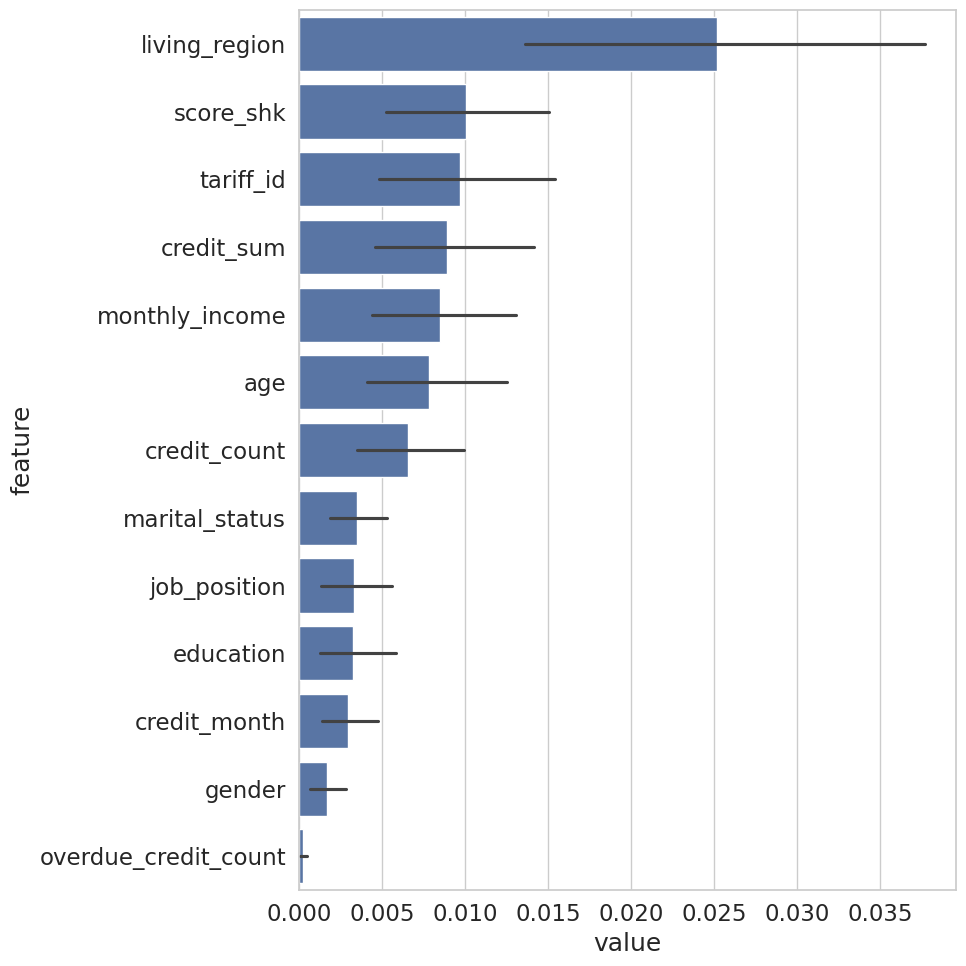

In [ ]:
def adversarial_make_target(train, adversarial_frac, col_adversarial, col_date, **kwargs):
    target_ind = train.sort_values(col_date)[-int(train.shape[0] * adversarial_frac):].index
    train[col_adversarial] = train.index.isin(target_ind).astype(int)
    return train
df = adversarial_make_target(df, **params)
params_adversarial = dict(params)
params_adversarial.update({'col_target':params['col_adversarial']})
params_adversarial['cols_exclude'].append('id_contract')
fig, shap_df, report, model_class = model_fit(df, **params_adversarial)

In [ ]:
print(report)

{
    "col_target": "target_adversarial",
    "feature_len": "13",
    "frac": [
        "0.50114",
        "0.50455",
        "0.50067",
        "0.50375",
        "0.50396",
        "0.50200",
        "0.50919",
        "0.50543",
        "0.50309",
        "0.50640"
    ],
    "loss": "-0.50165",
    "num_boost": "26",
    "score_max": "0.50165",
    "scores_all": [
        "0.50114",
        "0.50455",
        "0.50067",
        "0.50375",
        "0.50396",
        "0.50200",
        "0.50919",
        "0.50543",
        "0.50309",
        "0.50640"
    ],
    "shap_df": "|    | feature              |       mean |         std |\n|---:|:---------------------|-----------:|------------:|\n|  0 | living_region        | 0.0251343  | 0.0210757   |\n|  1 | score_shk            | 0.0100221  | 0.00890386  |\n|  2 | tariff_id            | 0.00965497 | 0.00876879  |\n|  3 | credit_sum           | 0.00888506 | 0.00826049  |\n|  4 | monthly_income       | 0.0084459  | 0.00750663  |\n|  5 | age

#### One factor analysis

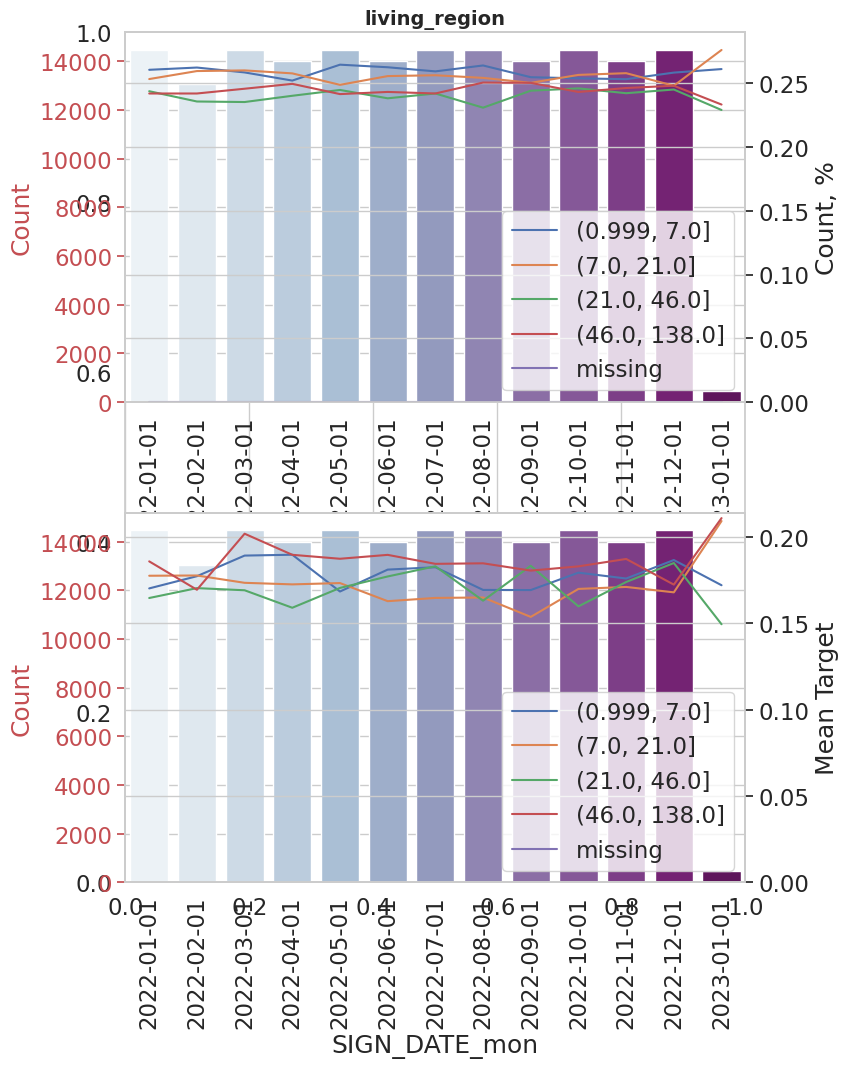

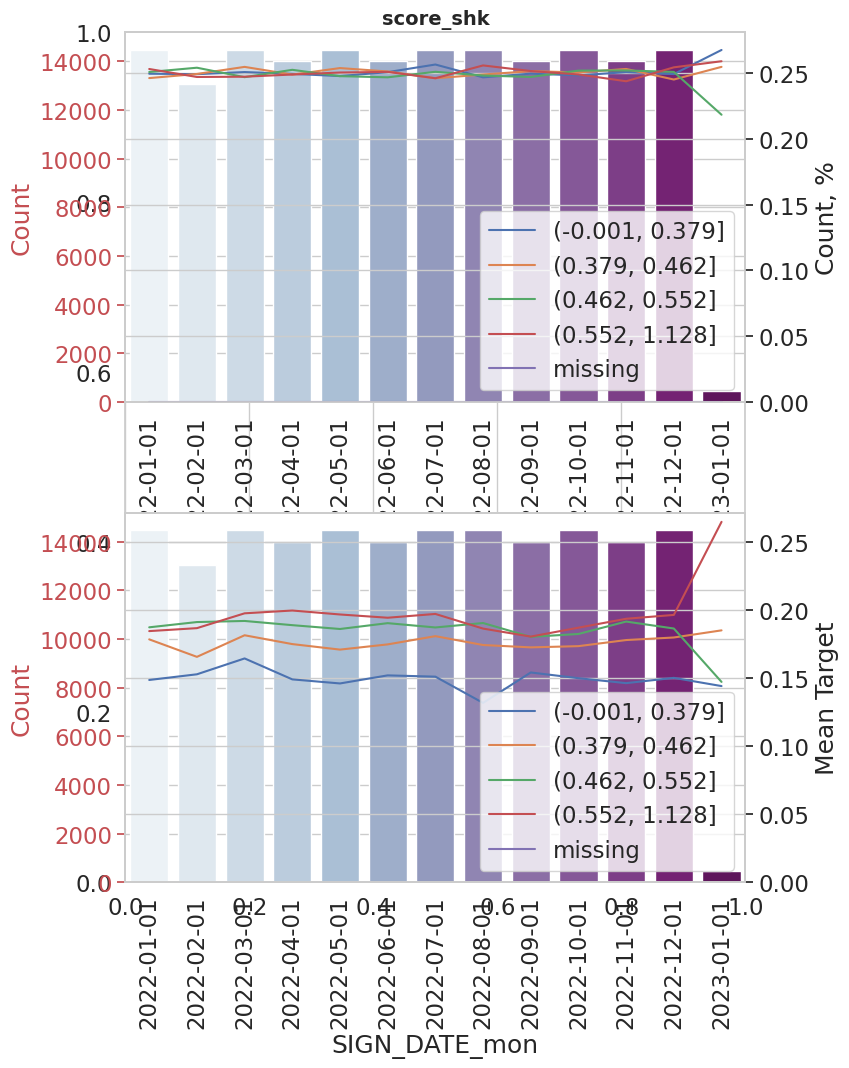

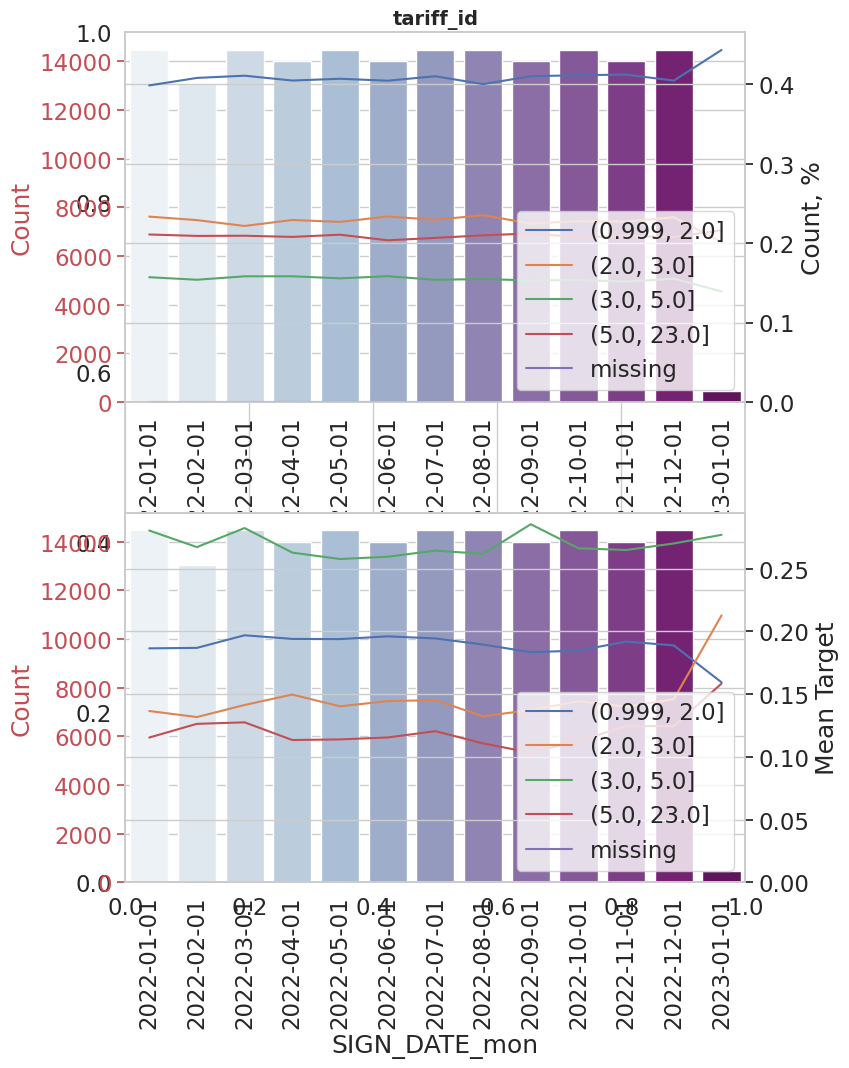

In [ ]:
report_onefactor = onefactor(df, shap_df, col_date=params['col_date_mon'],
          col_target=params['col_target'],
          report_directory='report',
        output_file='README_onefactor_unstable.md',
          top_features=3)

#### Model fit on all data

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.818511	eval's auc: 0.763102
[100]	train's auc: 0.84452	eval's auc: 0.766786
[150]	train's auc: 0.868904	eval's auc: 0.768068
[200]	train's auc: 0.891038	eval's auc: 0.767271
Early stopping, best iteration is:
[152]	train's auc: 0.869666	eval's auc: 0.768136
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.82032	eval's auc: 0.757166
[100]	train's auc: 0.845756	eval's auc: 0.759405
[150]	train's auc: 0.869759	eval's auc: 0.7603
[200]	train's auc: 0.891951	eval's auc: 0.760147
Early stopping, best iteration is:
[189]	train's auc: 0.887271	eval's auc: 0.760501
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.819287	eval's auc: 0.761947
[100]	train's auc: 0.845588	eval's auc: 0.765096
[150]	train's auc: 0.869883	eval's auc: 0.765225
Early stopping, best iteration is:
[142]	train's auc: 0.866123	eval's auc: 0.765554
Training until validation scores 

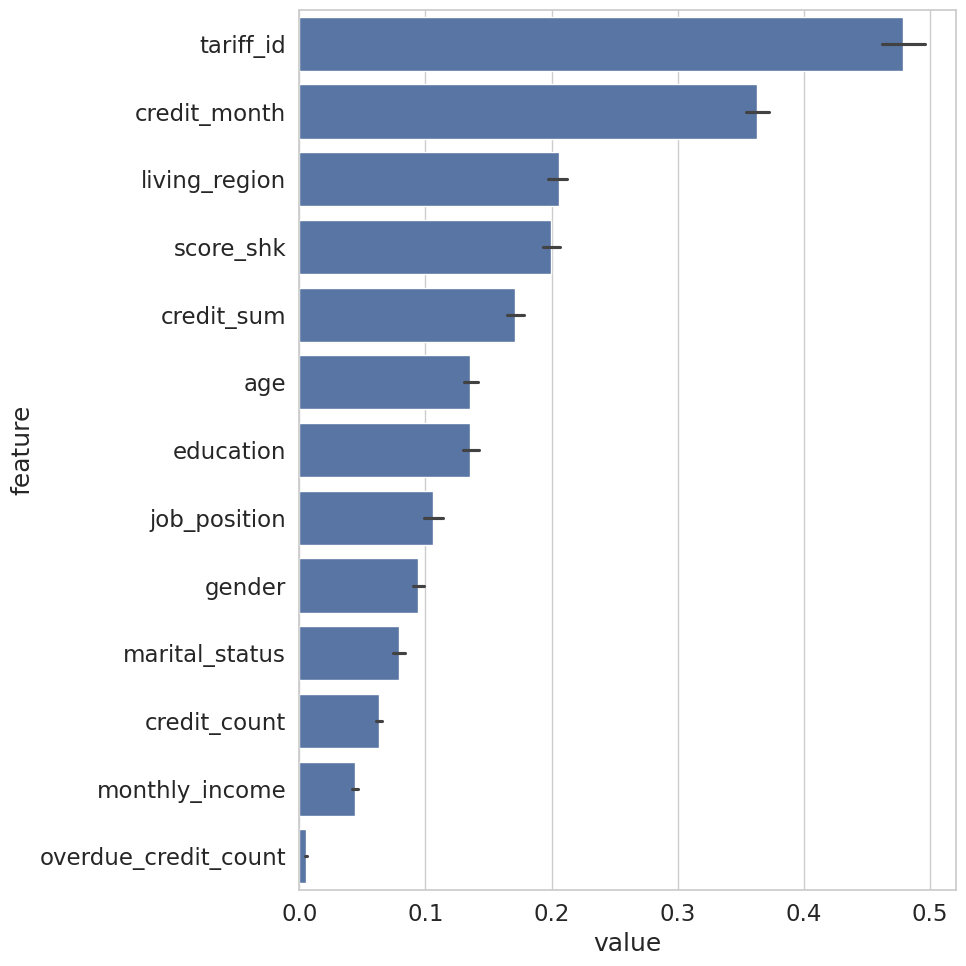

In [ ]:
fig, shap_df, report, model_class = model_fit(train, **params)

In [ ]:
shap_df

feature      mean       std
0              tariff_id  0.478887  0.028469
1           credit_month  0.362553  0.015968
2          living_region  0.205516  0.013337
3              score_shk  0.199457  0.011271
4             credit_sum  0.170913  0.010910
5                    age  0.135642  0.009329
6              education  0.135583  0.010784
7           job_position  0.106219  0.013636
8                 gender  0.094391  0.007496
9         marital_status  0.078792  0.007783
10          credit_count  0.063113  0.004711
11        monthly_income  0.043942  0.004545
12  overdue_credit_count  0.005153  0.001392

#### Forward selection

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.627258	eval's auc: 0.637079
[100]	train's auc: 0.627265	eval's auc: 0.637093
Did not meet early stopping. Best iteration is:
[92]	train's auc: 0.627265	eval's auc: 0.637093
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.629828	eval's auc: 0.626865
[100]	train's auc: 0.629838	eval's auc: 0.626854
Did not meet early stopping. Best iteration is:
[46]	train's auc: 0.629828	eval's auc: 0.626865
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.629267	eval's auc: 0.628301
[100]	train's auc: 0.629274	eval's auc: 0.628306
Did not meet early stopping. Best iteration is:
[35]	train's auc: 0.628923	eval's auc: 0.628308
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.63039	eval's auc: 0.624041
[100]	train's auc: 0.630398	eval's auc: 0.624044
Did not meet early stopping. Best iteration is:
[44]	train's auc: 0.630381	ev

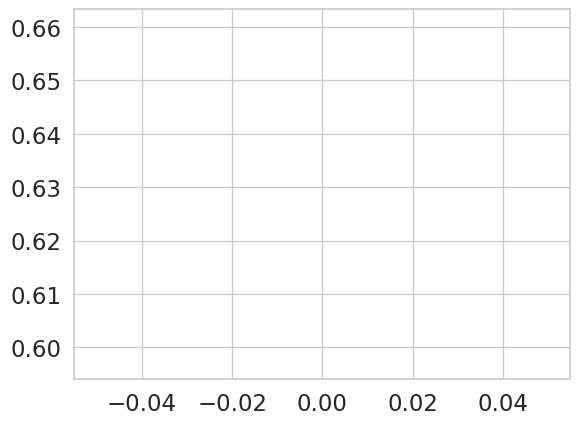

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.685804	eval's auc: 0.680982
[100]	train's auc: 0.691156	eval's auc: 0.679846
Did not meet early stopping. Best iteration is:
[41]	train's auc: 0.684172	eval's auc: 0.681496
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.68748	eval's auc: 0.67471
[100]	train's auc: 0.692994	eval's auc: 0.673385
Did not meet early stopping. Best iteration is:
[32]	train's auc: 0.684353	eval's auc: 0.675354
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.687509	eval's auc: 0.674626
[100]	train's auc: 0.692996	eval's auc: 0.672514
Did not meet early stopping. Best iteration is:
[21]	train's auc: 0.682129	eval's auc: 0.676322
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.688787	eval's auc: 0.669104
[100]	train's auc: 0.694118	eval's auc: 0.667257
Did not meet early stopping. Best iteration is:
[21]	train's auc: 0.6831	eval'

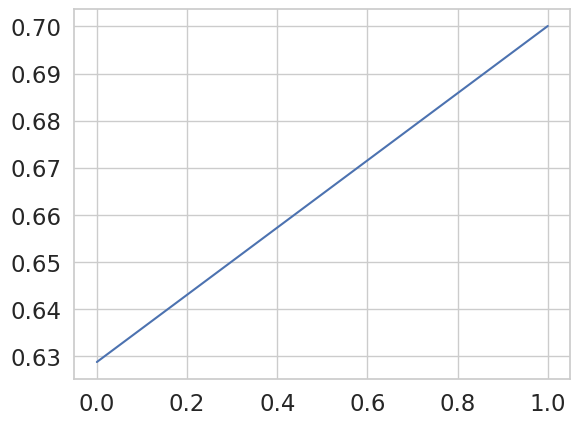

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.731021	eval's auc: 0.723577
[100]	train's auc: 0.738101	eval's auc: 0.723007
Did not meet early stopping. Best iteration is:
[46]	train's auc: 0.730277	eval's auc: 0.723958
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.732369	eval's auc: 0.718527
[100]	train's auc: 0.739974	eval's auc: 0.717604
Did not meet early stopping. Best iteration is:
[41]	train's auc: 0.730477	eval's auc: 0.718587
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.731283	eval's auc: 0.723217
[100]	train's auc: 0.738107	eval's auc: 0.721572
Did not meet early stopping. Best iteration is:
[33]	train's auc: 0.727801	eval's auc: 0.723285
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.731603	eval's auc: 0.721726
[100]	train's auc: 0.739276	eval's auc: 0.719893
Did not meet early stopping. Best iteration is:
[35]	train's auc: 0.728584	e

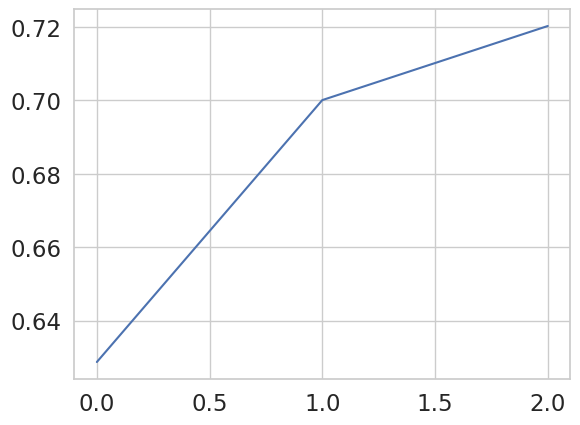

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.735864	eval's auc: 0.726397
[100]	train's auc: 0.744738	eval's auc: 0.726327
Did not meet early stopping. Best iteration is:
[30]	train's auc: 0.730821	eval's auc: 0.726822
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.737696	eval's auc: 0.721121
[100]	train's auc: 0.746431	eval's auc: 0.720694
Did not meet early stopping. Best iteration is:
[44]	train's auc: 0.736449	eval's auc: 0.721369
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.736157	eval's auc: 0.727574
[100]	train's auc: 0.744812	eval's auc: 0.726514
Did not meet early stopping. Best iteration is:
[42]	train's auc: 0.734042	eval's auc: 0.72775
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.736439	eval's auc: 0.725506
[100]	train's auc: 0.744958	eval's auc: 0.724191
Did not meet early stopping. Best iteration is:
[47]	train's auc: 0.735664	ev

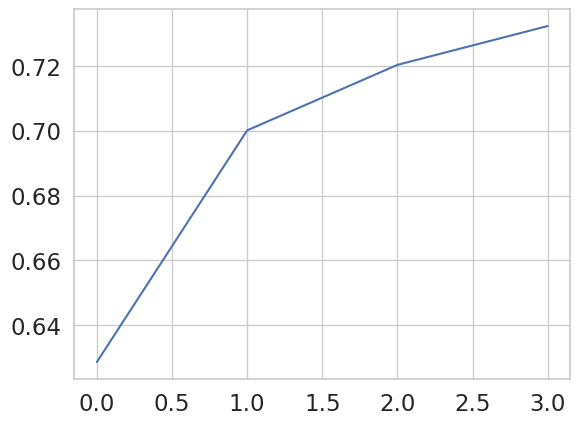

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.750378	eval's auc: 0.740781
[100]	train's auc: 0.764126	eval's auc: 0.739718
Did not meet early stopping. Best iteration is:
[48]	train's auc: 0.74972	eval's auc: 0.740869
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.751878	eval's auc: 0.73509
[100]	train's auc: 0.765306	eval's auc: 0.735008
Did not meet early stopping. Best iteration is:
[73]	train's auc: 0.758805	eval's auc: 0.735488
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.751432	eval's auc: 0.736746
[100]	train's auc: 0.764359	eval's auc: 0.735879
Did not meet early stopping. Best iteration is:
[65]	train's auc: 0.756277	eval's auc: 0.736868
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.75168	eval's auc: 0.735463
[100]	train's auc: 0.765629	eval's auc: 0.734175
Did not meet early stopping. Best iteration is:
[51]	train's auc: 0.75199	eval'

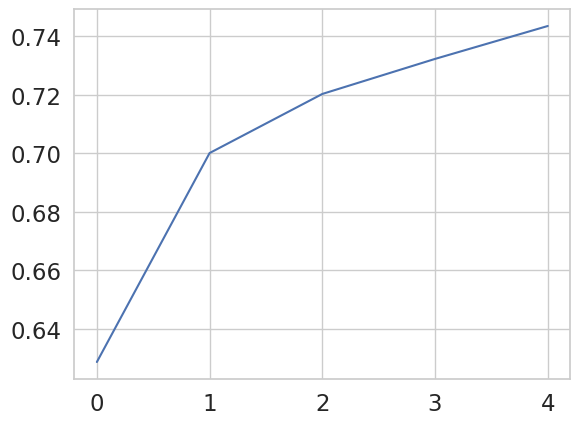

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.75956	eval's auc: 0.749028
[100]	train's auc: 0.774441	eval's auc: 0.748208
Did not meet early stopping. Best iteration is:
[52]	train's auc: 0.760363	eval's auc: 0.749148
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.761289	eval's auc: 0.742594
[100]	train's auc: 0.775836	eval's auc: 0.742462
Did not meet early stopping. Best iteration is:
[87]	train's auc: 0.772474	eval's auc: 0.742944
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.760513	eval's auc: 0.745394
[100]	train's auc: 0.774333	eval's auc: 0.745627
Did not meet early stopping. Best iteration is:
[74]	train's auc: 0.767726	eval's auc: 0.746029
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.760459	eval's auc: 0.743723
[100]	train's auc: 0.774914	eval's auc: 0.743022
Did not meet early stopping. Best iteration is:
[51]	train's auc: 0.760927	ev

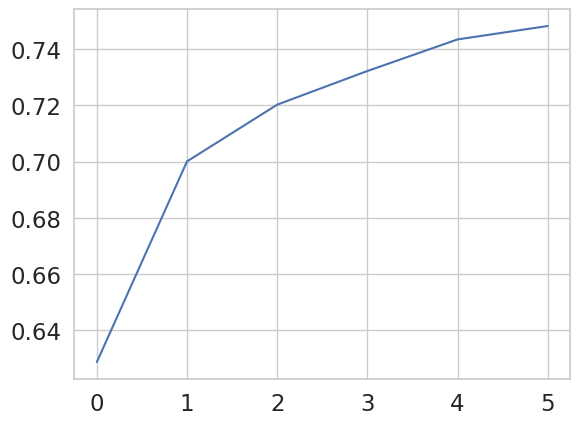

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.763735	eval's auc: 0.754309
[100]	train's auc: 0.778709	eval's auc: 0.754481
Did not meet early stopping. Best iteration is:
[63]	train's auc: 0.767977	eval's auc: 0.755164
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.765649	eval's auc: 0.745562
[100]	train's auc: 0.779905	eval's auc: 0.747063
Did not meet early stopping. Best iteration is:
[99]	train's auc: 0.779642	eval's auc: 0.747103
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.765063	eval's auc: 0.749693
[100]	train's auc: 0.779417	eval's auc: 0.749979
Did not meet early stopping. Best iteration is:
[80]	train's auc: 0.774334	eval's auc: 0.750352
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.765184	eval's auc: 0.747509
[100]	train's auc: 0.77965	eval's auc: 0.747926
Did not meet early stopping. Best iteration is:
[63]	train's auc: 0.769442	ev

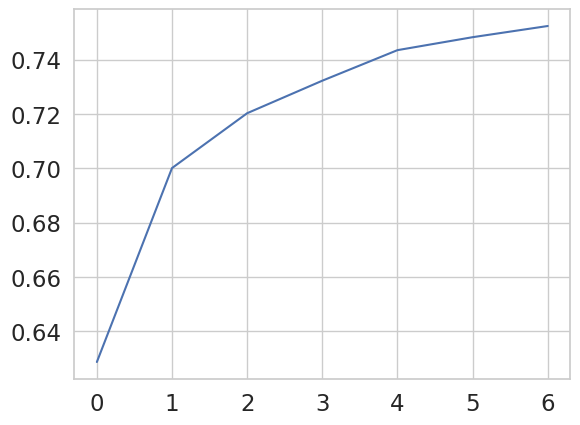

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.767808	eval's auc: 0.755626
[100]	train's auc: 0.786628	eval's auc: 0.757603
Did not meet early stopping. Best iteration is:
[96]	train's auc: 0.785429	eval's auc: 0.757641
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.770021	eval's auc: 0.749131
[100]	train's auc: 0.786524	eval's auc: 0.750381
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.786524	eval's auc: 0.750381
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.768664	eval's auc: 0.753372
[100]	train's auc: 0.786798	eval's auc: 0.755047
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.786798	eval's auc: 0.755047
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.770391	eval's auc: 0.750953
[100]	train's auc: 0.787184	eval's auc: 0.752954
Did not meet early stopping. Best iteration is:
[95]	train's auc: 0.785779

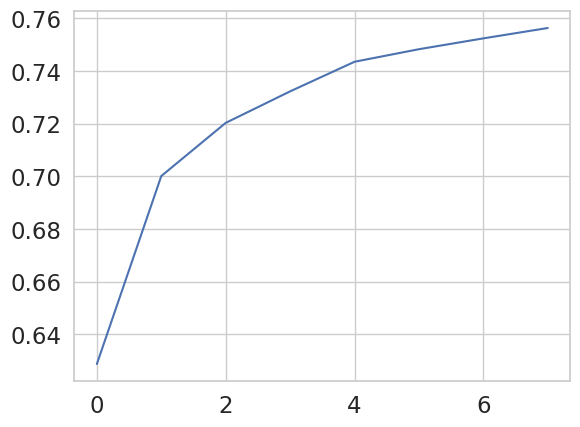

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.772281	eval's auc: 0.76065
[100]	train's auc: 0.789476	eval's auc: 0.762175
Did not meet early stopping. Best iteration is:
[84]	train's auc: 0.784382	eval's auc: 0.762324
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.774084	eval's auc: 0.751552
[100]	train's auc: 0.791104	eval's auc: 0.753552
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.791104	eval's auc: 0.753552
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.77254	eval's auc: 0.757602
[100]	train's auc: 0.790642	eval's auc: 0.759791
Did not meet early stopping. Best iteration is:
[98]	train's auc: 0.789994	eval's auc: 0.759882
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.773558	eval's auc: 0.754463
[100]	train's auc: 0.792097	eval's auc: 0.756255
Did not meet early stopping. Best iteration is:
[97]	train's auc: 0.791115	ev

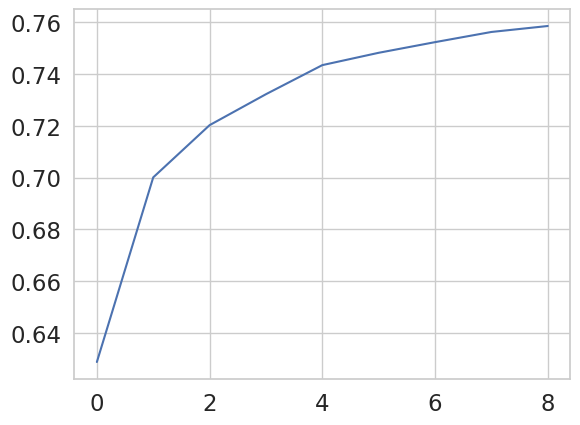

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.773926	eval's auc: 0.761781
[100]	train's auc: 0.792215	eval's auc: 0.763573
Did not meet early stopping. Best iteration is:
[92]	train's auc: 0.789759	eval's auc: 0.763713
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.77606	eval's auc: 0.753887
[100]	train's auc: 0.793498	eval's auc: 0.755696
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.793498	eval's auc: 0.755696
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.774646	eval's auc: 0.760249
[100]	train's auc: 0.792578	eval's auc: 0.762605
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.792578	eval's auc: 0.762605
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.775739	eval's auc: 0.756884
[100]	train's auc: 0.793898	eval's auc: 0.758287
Did not meet early stopping. Best iteration is:
[99]	train's auc: 0.793605	

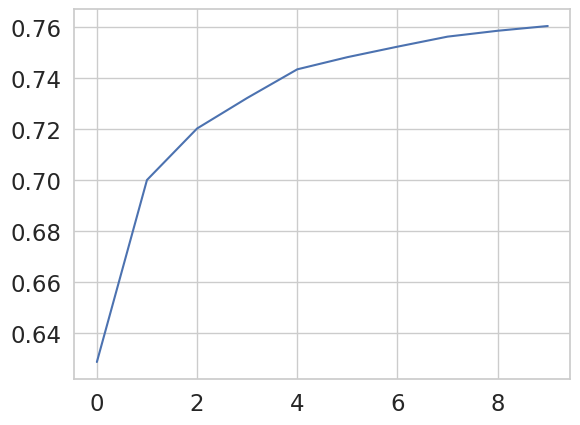

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.776598	eval's auc: 0.763824
[100]	train's auc: 0.796481	eval's auc: 0.766356
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.796481	eval's auc: 0.766356
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.77844	eval's auc: 0.754356
[100]	train's auc: 0.796846	eval's auc: 0.757724
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.796846	eval's auc: 0.757724
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.777031	eval's auc: 0.761986
[100]	train's auc: 0.79578	eval's auc: 0.765241
Did not meet early stopping. Best iteration is:
[88]	train's auc: 0.791976	eval's auc: 0.765725
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778336	eval's auc: 0.759124
[100]	train's auc: 0.797903	eval's auc: 0.761692
Did not meet early stopping. Best iteration is:
[99]	train's auc: 0.797573	e

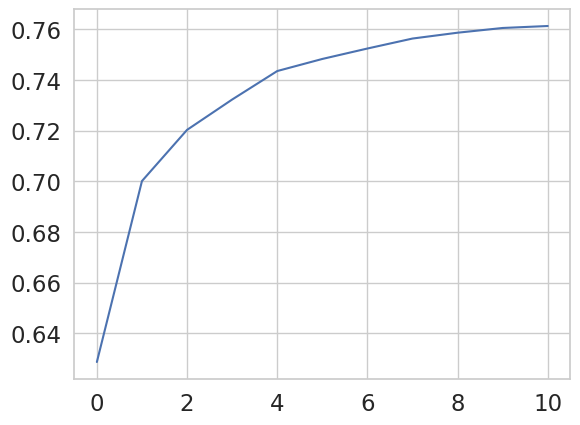

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.77816	eval's auc: 0.763596
[100]	train's auc: 0.797719	eval's auc: 0.765105
Did not meet early stopping. Best iteration is:
[95]	train's auc: 0.796329	eval's auc: 0.7653
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.779651	eval's auc: 0.755506
[100]	train's auc: 0.798441	eval's auc: 0.758795
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.798441	eval's auc: 0.758795
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778102	eval's auc: 0.761651
[100]	train's auc: 0.797509	eval's auc: 0.764046
Did not meet early stopping. Best iteration is:
[96]	train's auc: 0.796099	eval's auc: 0.764305
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778698	eval's auc: 0.759068
[100]	train's auc: 0.798092	eval's auc: 0.761118
Did not meet early stopping. Best iteration is:
[83]	train's auc: 0.792404	eva

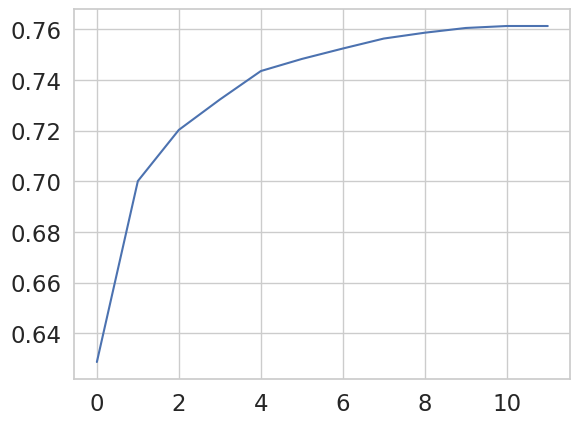

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778334	eval's auc: 0.763731
[100]	train's auc: 0.798011	eval's auc: 0.76581
Did not meet early stopping. Best iteration is:
[98]	train's auc: 0.797218	eval's auc: 0.765842
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.779159	eval's auc: 0.755164
[100]	train's auc: 0.798703	eval's auc: 0.758555
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.798703	eval's auc: 0.758555
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778211	eval's auc: 0.761758
[100]	train's auc: 0.798093	eval's auc: 0.764485
Did not meet early stopping. Best iteration is:
[96]	train's auc: 0.796655	eval's auc: 0.764603
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.778938	eval's auc: 0.75944
[100]	train's auc: 0.798754	eval's auc: 0.761392
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.798754	e

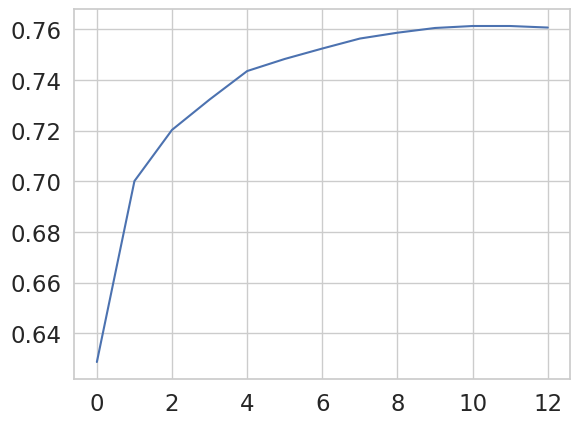

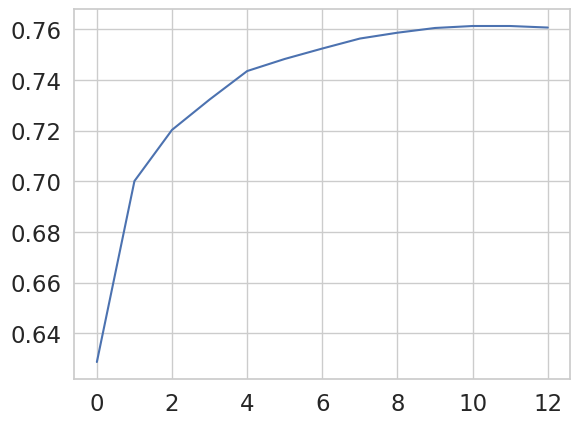

In [ ]:
params_fs = dict(params)
params_fs['feature_name'] = shap_df['feature'].values.tolist()
scores_df, top_features = forward_selection(train, **params_fs)

In [ ]:
import json
top_features = int(json.loads(top_features)['feature_selection'])

In [ ]:
top_features

11

#### Hyperopt

In [ ]:
params_hp = dict(params_fs)
params_hp['feature_name']=scores_df['index'][:top_features].values.tolist()

In [ ]:
results = hyperopt_fit(train, **params_hp)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.812167	eval's auc: 0.760848
[100]	train's auc: 0.840749	eval's auc: 0.762866
[150]	train's auc: 0.868044	eval's auc: 0.762802
Early stopping, best iteration is:
[134]	train's auc: 0.859353	eval's auc: 0.763323
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.812874	eval's auc: 0.752428
[100]	train's auc: 0.84163	eval's auc: 0.755372
[150]	train's auc: 0.868246	eval's auc: 0.756075
[200]	train's auc: 0.891553	eval's auc: 0.755843
Early stopping, best iteration is:
[156]	train's auc: 0.871309	eval's auc: 0.756219
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.811783	eval's auc: 0.758554
[100]	train's auc: 0.840517	eval's auc: 0.760754
[150]	train's auc: 0.868323	eval's auc: 0.761167
Early stopping, best iteration is:
[145]	train's auc: 0.865432	eval's auc: 0.761473
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 

In [ ]:
print(results)


#### Fit final model

In [ ]:
params_hp['lgb_params'] = json.loads(results)['params']
fig, shap_df, report, model_class = model_fit(train, **params_hp)
fig = model_class.shap_summary_plot(train)
model_class.scores
model_class.num_boost_optimal
params_hp['num_boost'] = model_class.num_boost_optimal
params_hp['early_stopping'] = None
params_hp['cols_cat']=None
model_str, model = model_single_fit(train, **params_hp)

#### One factor analysis - features

In [ ]:
report_onefactor = onefactor(df, shap_df, col_date=params['col_date_mon'],
          col_target=params['col_target'],
          report_directory='report',
        output_file='README_onefactor_unstable.md',
          top_features=top_features)

#### Predict & Report

In [ ]:
train['predict_boosting'] = model_class.transform(train)
test['predict_boosting'] = model_class.predict(test)
test['predict_test'] = model.predict(test[model.feature_name()])

In [ ]:
a = ReportBinary()
a.plot_report(
    test,
    report_shape = (6,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(3, 0)},{'loc':(3, 1)},{'loc':(4, 0)}],
          'Gini-by-Generations': {'loc':(1,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(2,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(4,1)},{'loc':(5,0)},{'loc':(5,1)}]},
    cols_score = ['predict_boosting','predict','predict_test'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

In [ ]:
a = ReportBinary()
a.plot_report(
    pd.concat([train,test],axis=0),
    report_shape = (6,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(3, 0)},{'loc':(3, 1)},{'loc':(4, 0)}],
          'Gini-by-Generations': {'loc':(1,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(2,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(4,1)},{'loc':(5,0)},{'loc':(5,1)}]},
    cols_score = ['predict_boosting','predict','predict_test'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

## Feature importance stability

In [ ]:
params2 = '''
lgb_params:
  bagging_fraction: 0.849285747554019
  bagging_freq: 5
  bagging_seed: 0
  boosting_type: 'gbdt'
  data_random_seed: 0
  drop_seed: 0
  feature_fraction: 0.8212766928844304
  feature_fraction_seed: 0
  lambda_l1: 0.8955546599539566
  lambda_l2: 1.4423261095989717
  learning_rate: 0.03
  max_bin: 255
  max_depth': 43
  metric: 'auc'
  min_data_in_leaf: 149
  min_sum_hessian_in_leaf: 1.804477623298885
  num_leaves: 363
  objective: 'binary'
  seed: 0
  verbose: 0
n_repeats: 1
n_splits: 3
num_boost: 100
early_stopping: 50
col_target: 'open_account_flg'
col_client: 'id_client'
cv_byclient: False
cols_exclude: ['predict_stacking','predict_boosting','SIGN_DATE_mon','SIGN_DATE','open_account_flg','target_adversarial','predict']
cols_cat: ['tariff_id', 'gender','marital_status','job_position','living_region','education']

adversarial_frac: 0.25
col_date: 'SIGN_DATE'
col_date_mon: 'SIGN_DATE_mon'
col_adversarial: 'target_adversarial'

hyperopt_trials: 3
'''
with open('params2.yaml','w') as f:
    f.write(params2)
with open('params2.yaml') as f:
  params2 = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
pd.concat([shap_df.reset_index().set_index('feature')['index'],shap_df.reset_index().set_index('feature')['index']],axis=1)

index  index
feature                     
tariff_id           0      0
credit_month        1      1
living_region       2      2
score_shk           3      3
credit_sum          4      4
age                 5      5
education           6      6
job_position        7      7
gender              8      8
marital_status      9      9
credit_count       10     10

In [ ]:
def calc_fi(df, params):
  mon_array = sorted(df[params['col_date_mon']].unique())
  col_gini = np.zeros(len(mon_array))
  res = []
  for idx, mon in enumerate(mon_array):
    df_small = df[df[params['col_date_mon']] <= mon]
    fig, shap_df, report, model_class = model_fit(df_small, **params2)
    data = shap_df.reset_index().set_index('feature')[['index']].rename(columns={'index':mon})
    res.append(data)
  return res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

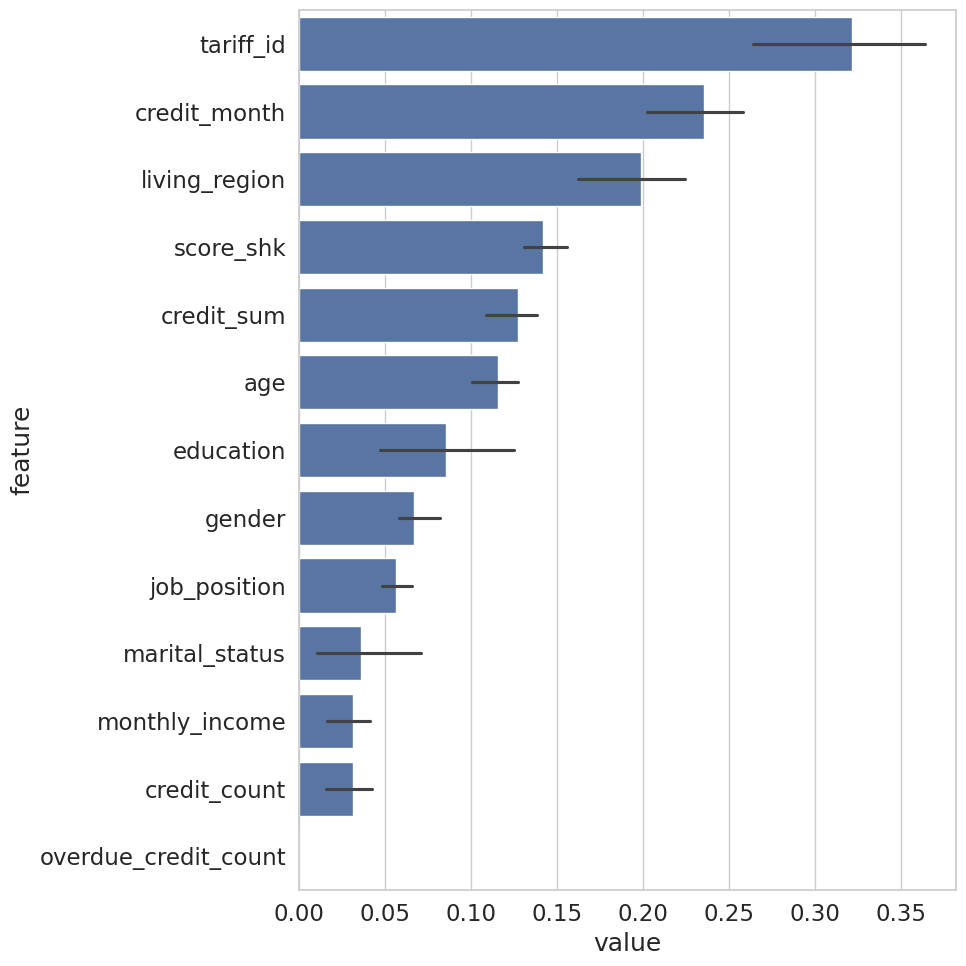

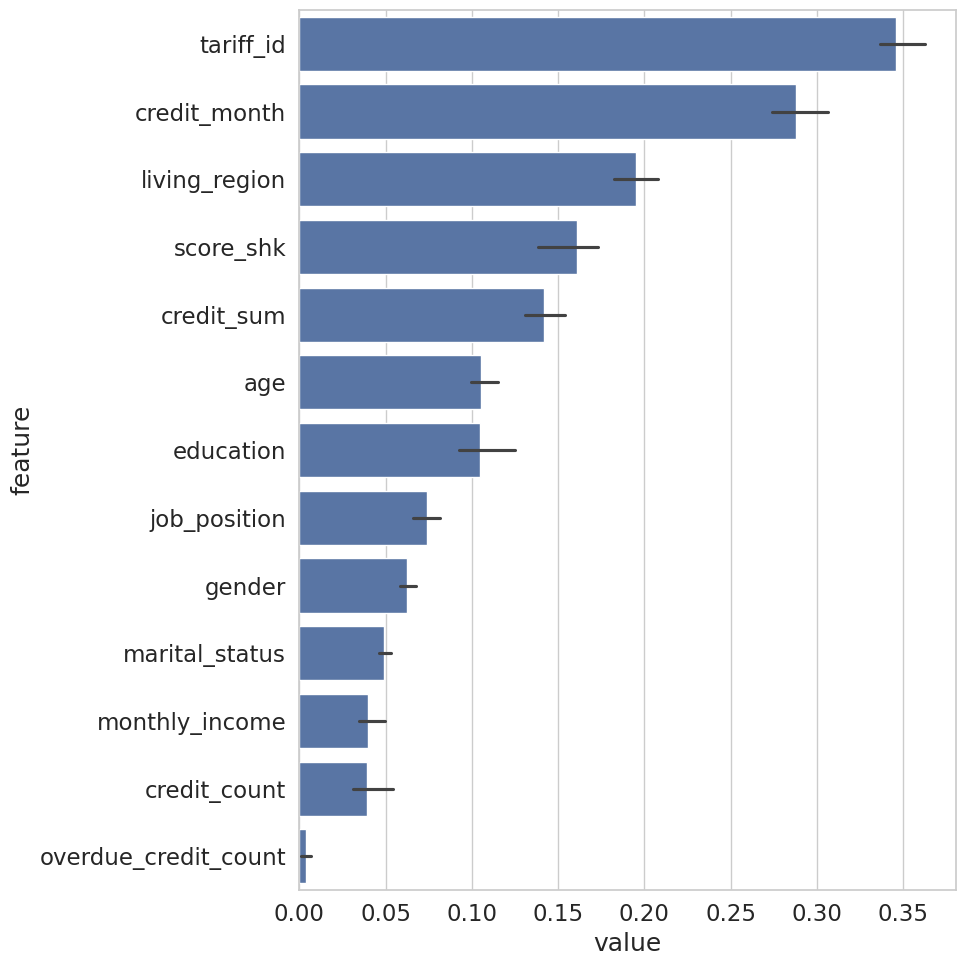

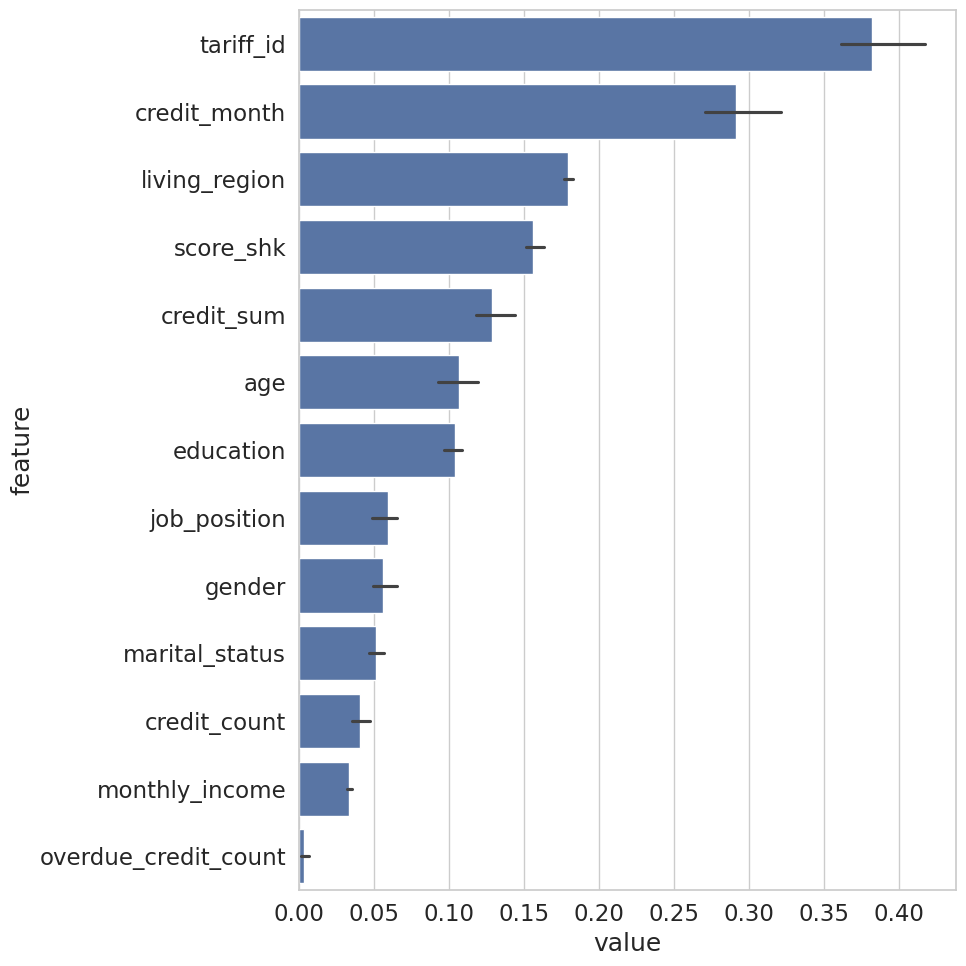

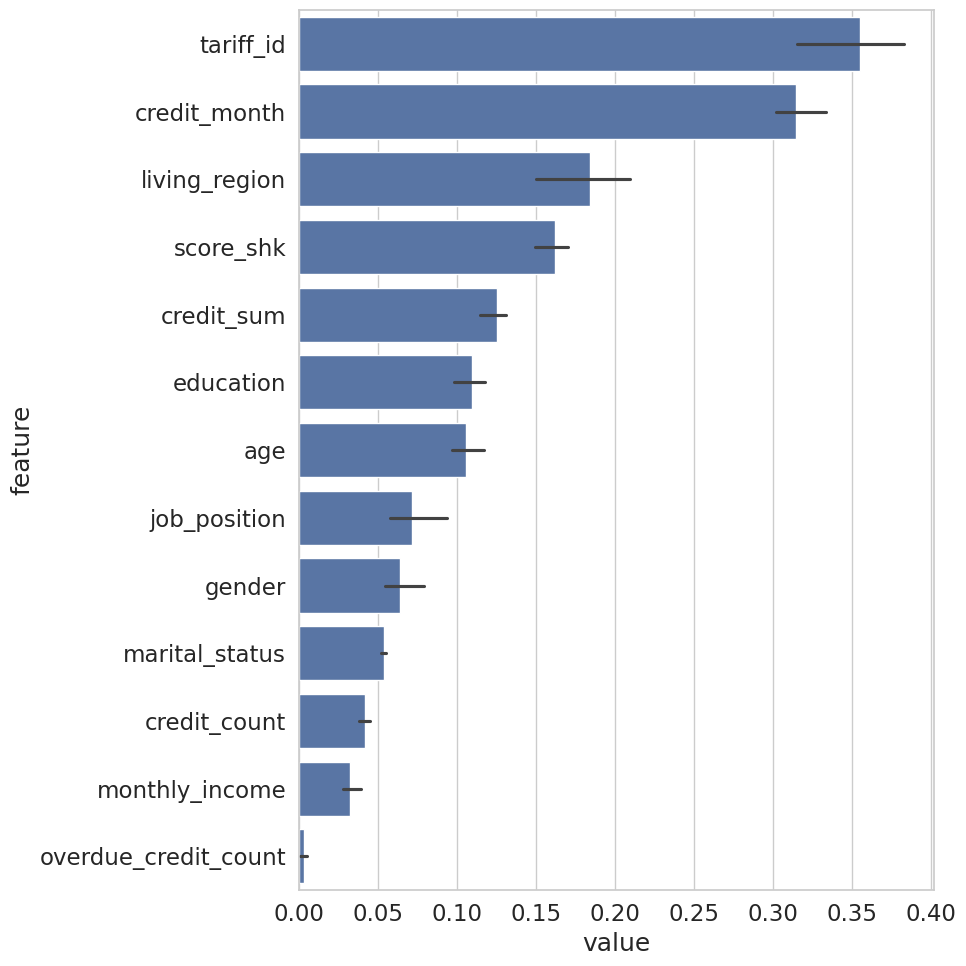

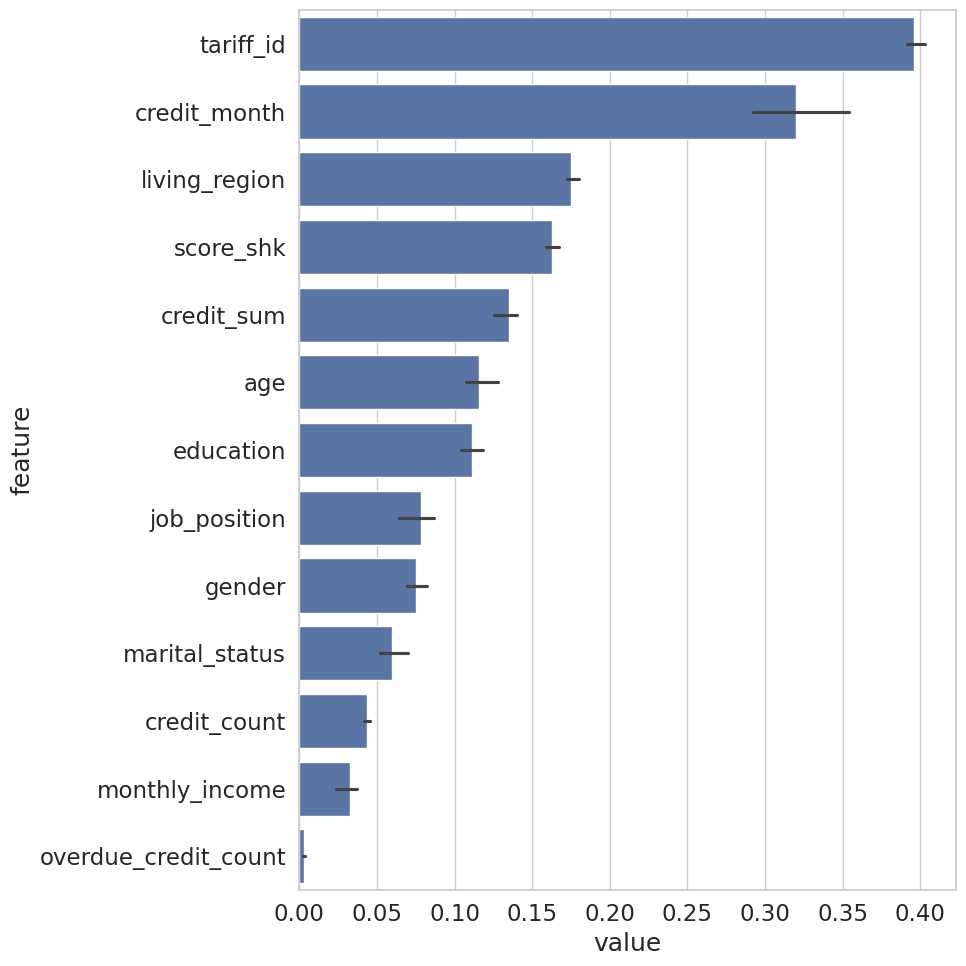

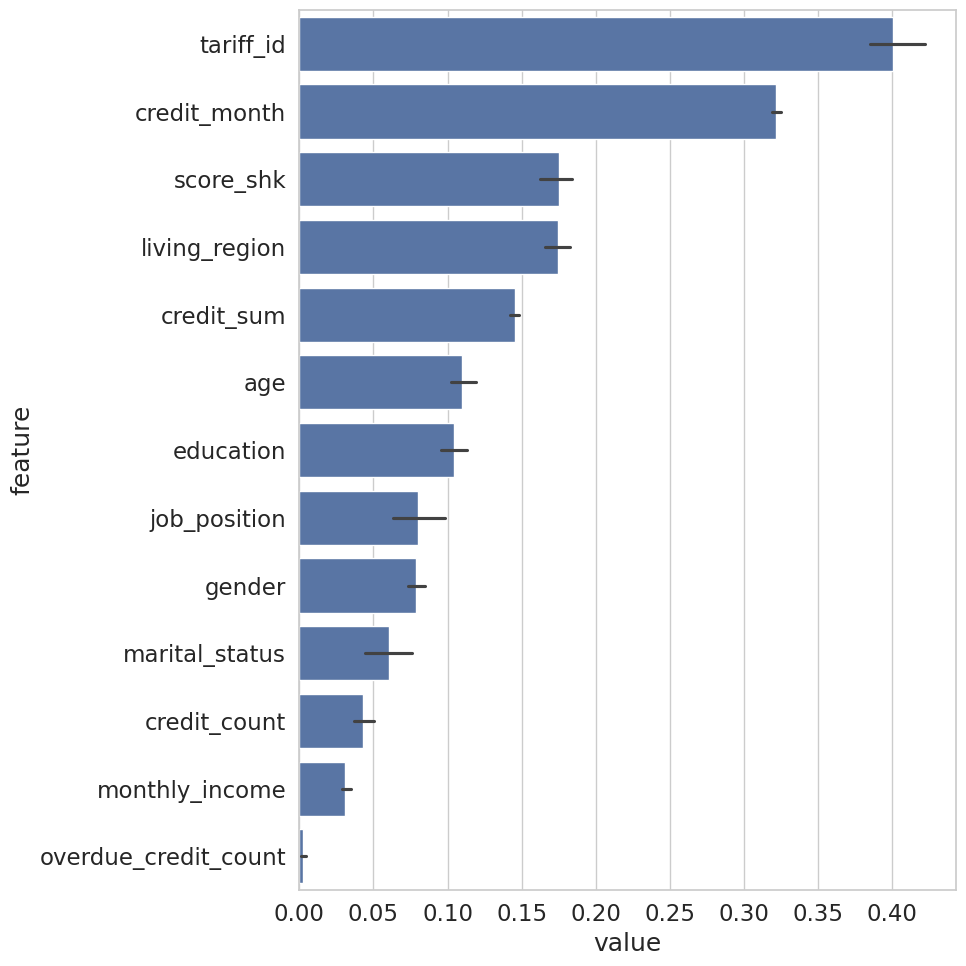

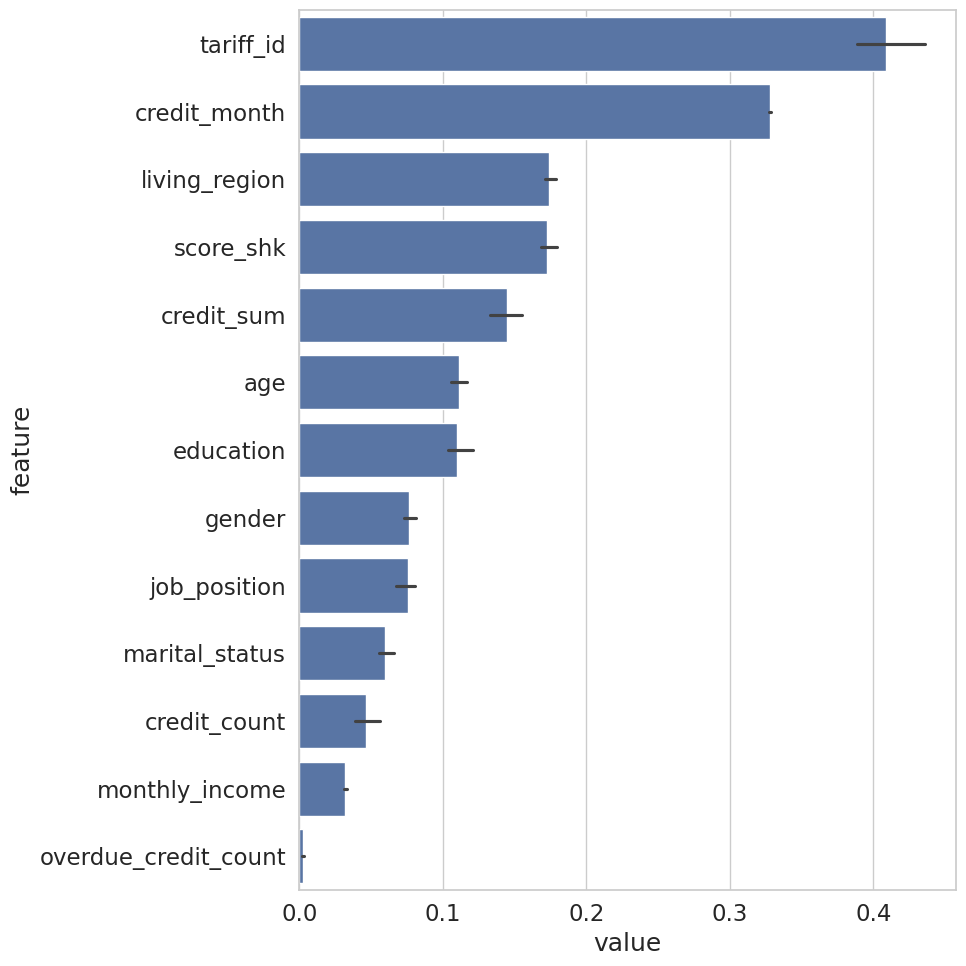

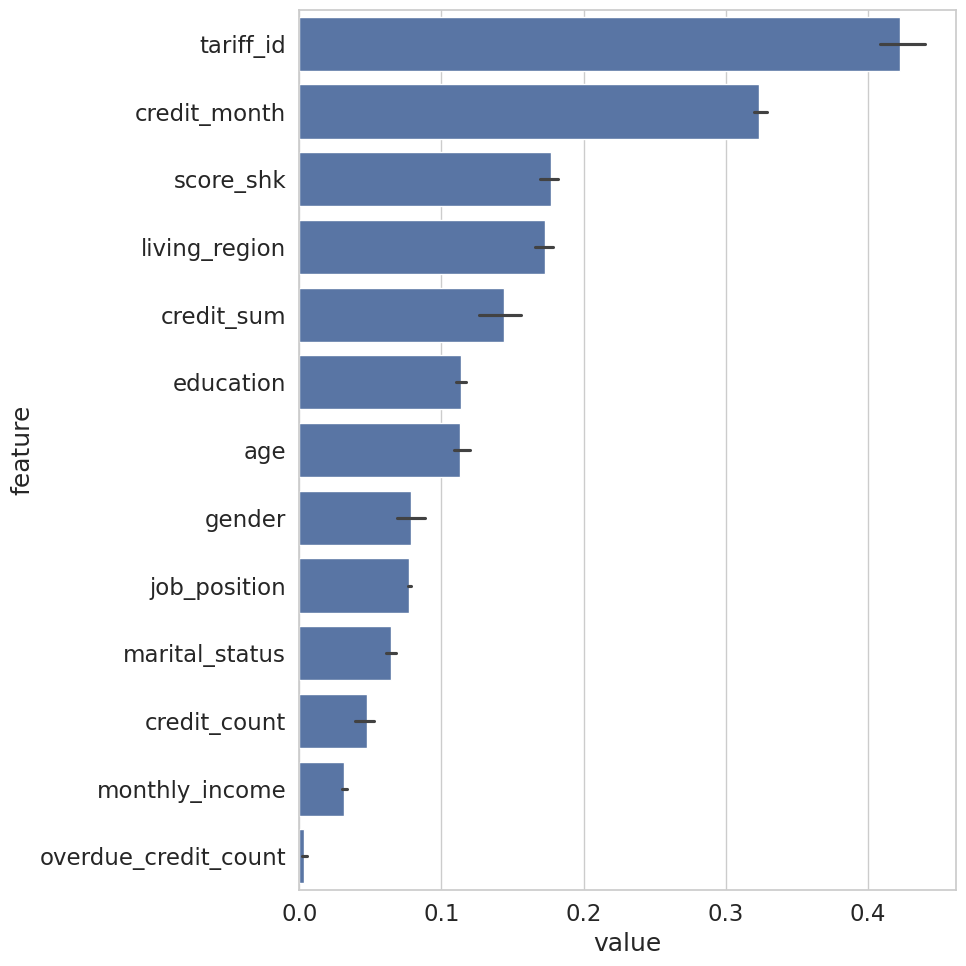

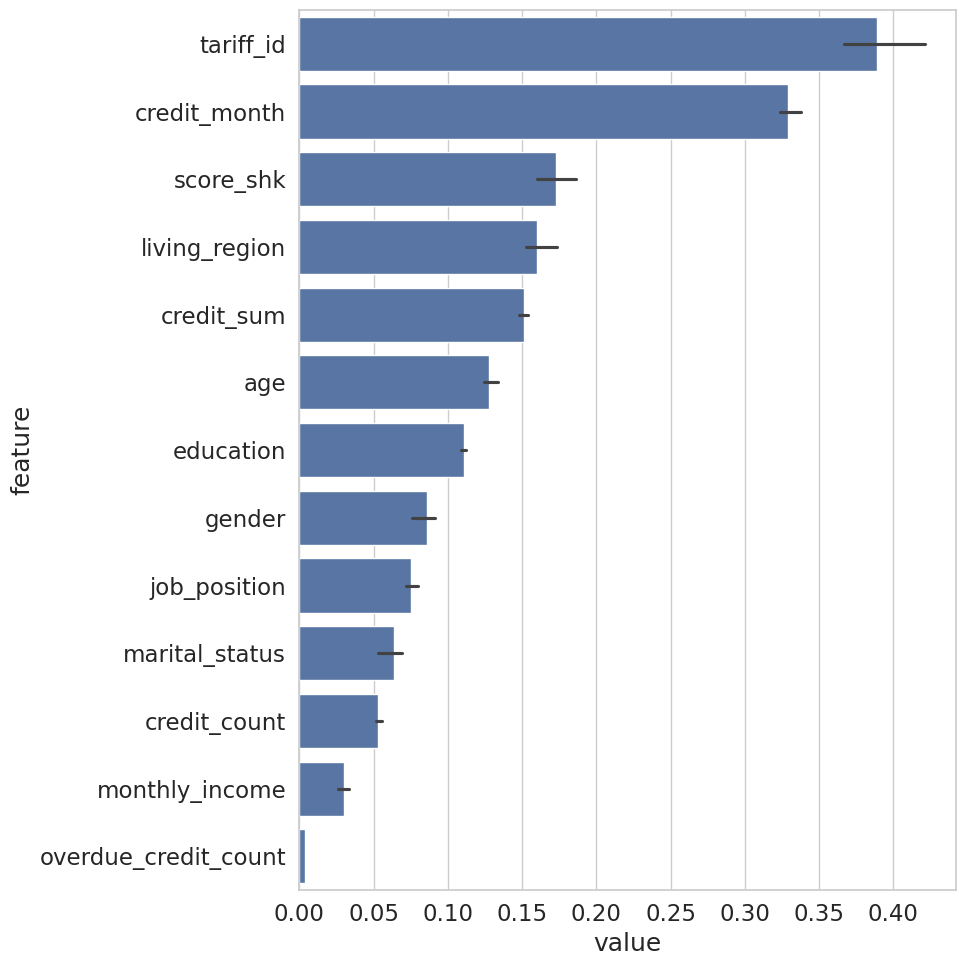

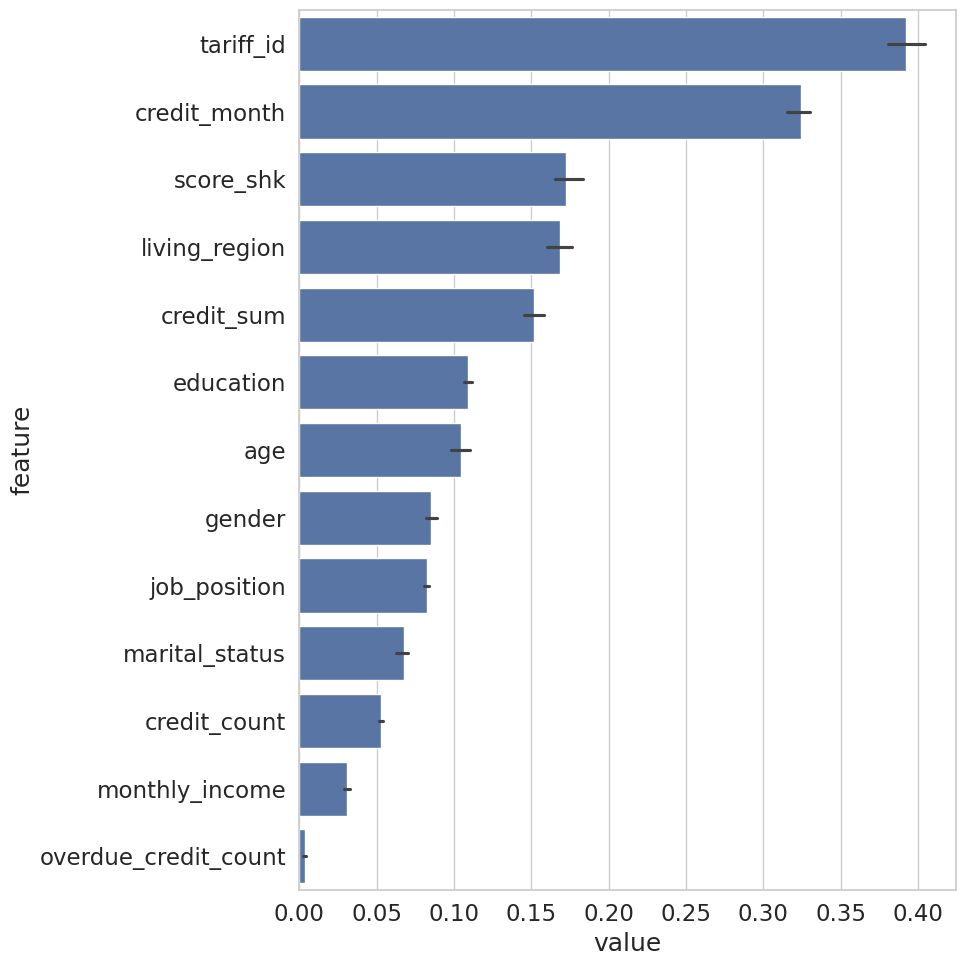

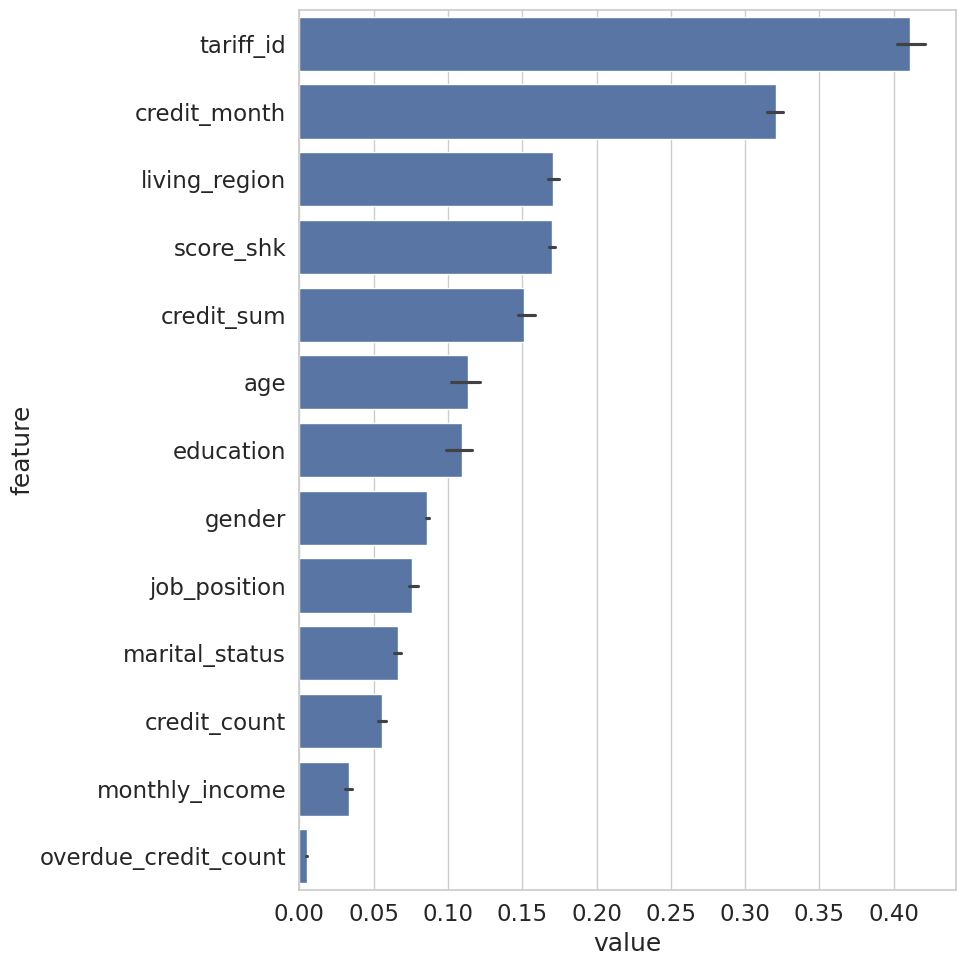

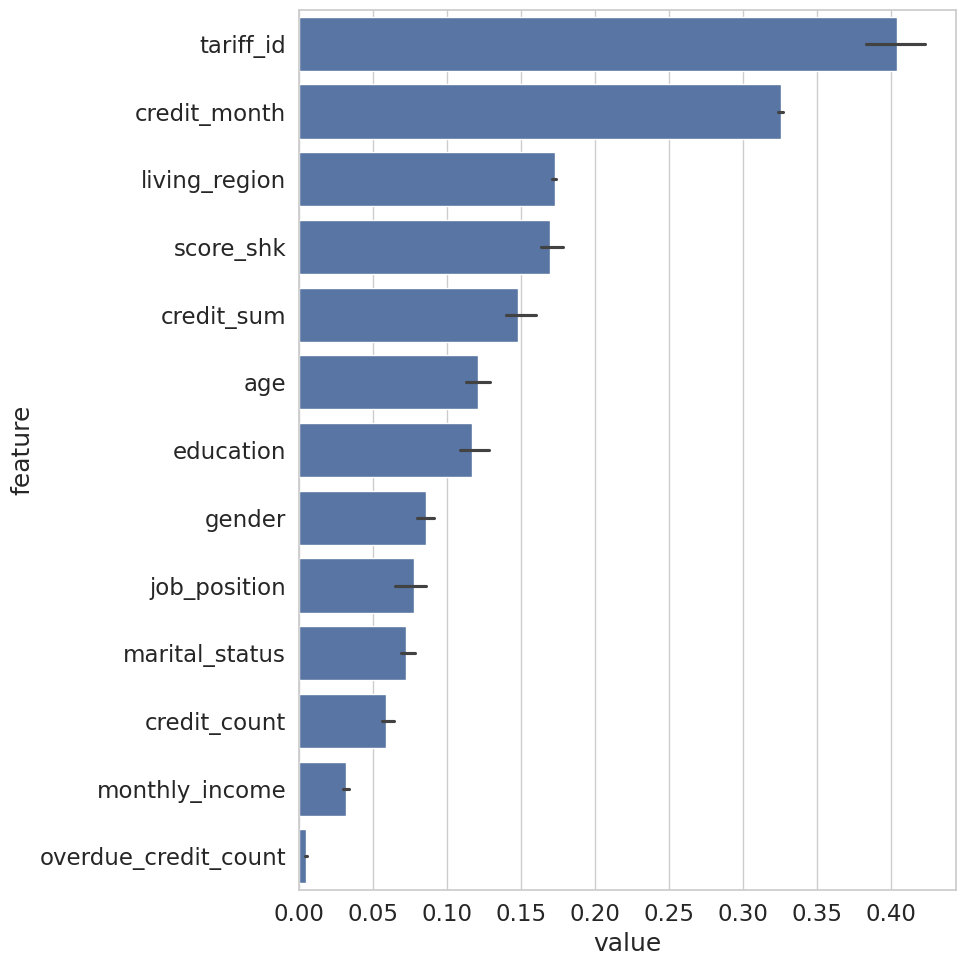

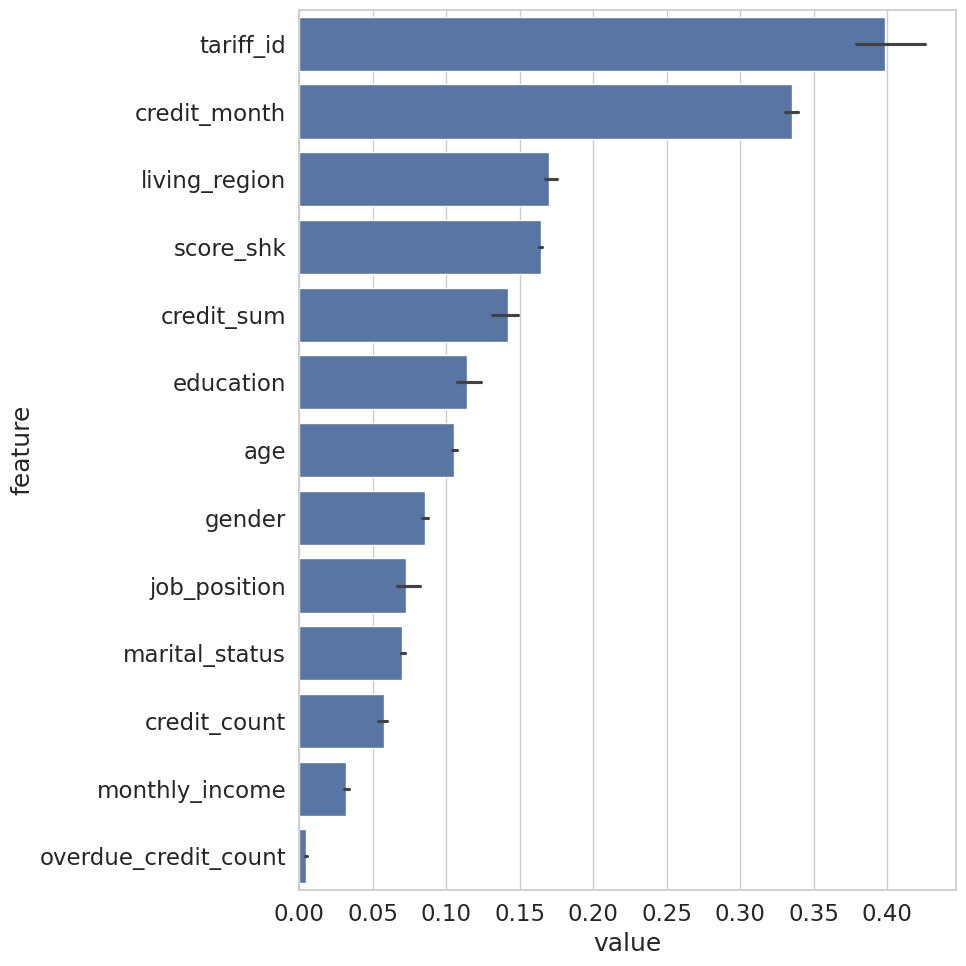

In [ ]:
res = calc_fi(df,params)

In [ ]:
res = pd.concat(res,axis=1)
res

2022-01-01  2022-02-01  2022-03-01  2022-04-01  \
feature                                                                
tariff_id                      0           0           0           0   
credit_month                   1           1           1           1   
living_region                  2           2           2           2   
score_shk                      3           3           3           3   
credit_sum                     4           4           4           4   
age                            5           5           5           6   
education                      6           6           6           5   
gender                         7           8           8           8   
job_position                   8           7           7           7   
marital_status                 9           9           9           9   
monthly_income                10          10          11          11   
credit_count                  11          11          10          10   
overdue_credit_count          12          12          12          12   

                      2022-05-01  2022-06-01  2022-07-01  2022-08-01  \
feature                                                                
tariff_id                      0           0           0           0   
credit_month                   1           1           1           1   
living_region                  2           3           2           3   
score_shk                      3           2           3           2   
credit_sum                     4           4           4           4   
age                            5           5           5           6   
education                      6           6           6           5   
gender                         8           8           7           7   
job_position                   7           7           8           8   
marital_status                 9           9           9           9   
monthly_income                11          11          11          11   
credit_count                  10          10          10          10   
overdue_credit_count          12          12          12          12   

                      2022-09-01  2022-10-01  2022-11-01  2022-12-01  \
feature                                                                
tariff_id                      0           0           0           0   
credit_month                   1           1           1           1   
living_region                  3           3           2           2   
score_shk                      2           2           3           3   
credit_sum                     4           4           4           4   
age                            5           6           5           5   
education                      6           5           6           6   
gender                         7           7           7           7   
job_position                   8           8           8           8   
marital_status                 9           9           9           9   
monthly_income                11          11          11          11   
credit_count                  10          10          10          10   
overdue_credit_count          12          12          12          12   

                      2023-01-01  
feature                           
tariff_id                      0  
credit_month                   1  
living_region                  2  
score_shk                      3  
credit_sum                     4  
age                            6  
education                      5  
gender                         7  
job_position                   8  
marital_status                 9  
monthly_income                11  
credit_count                  10  
overdue_credit_count          12

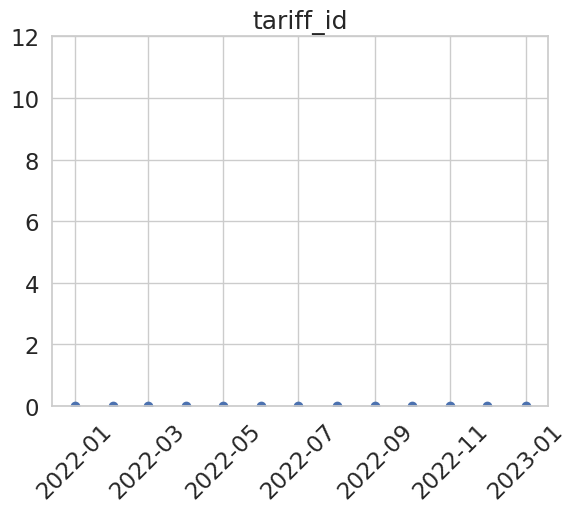

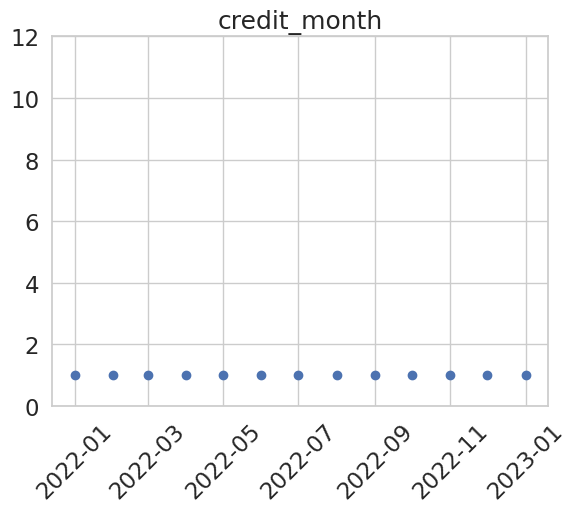

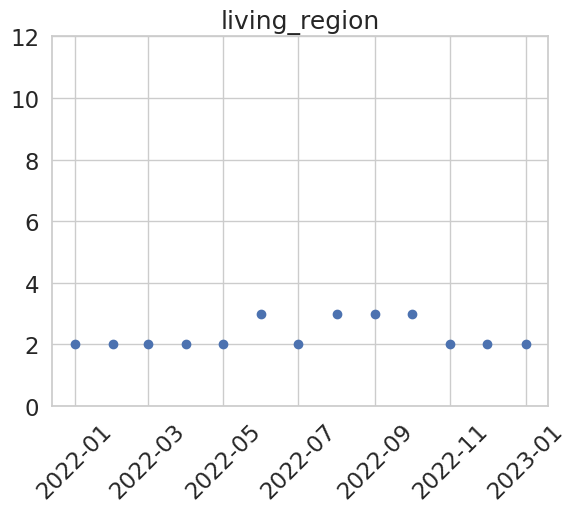

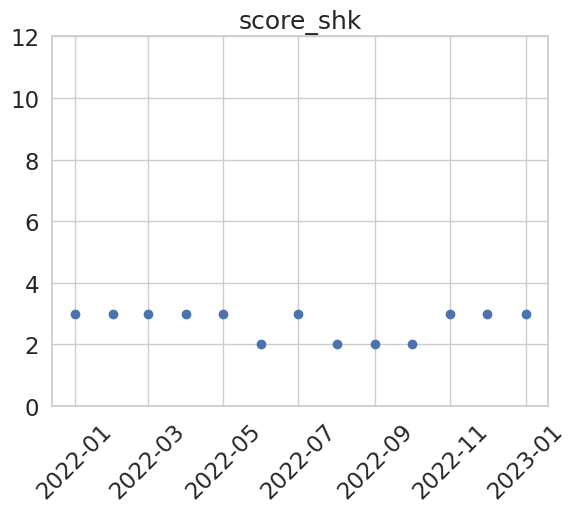

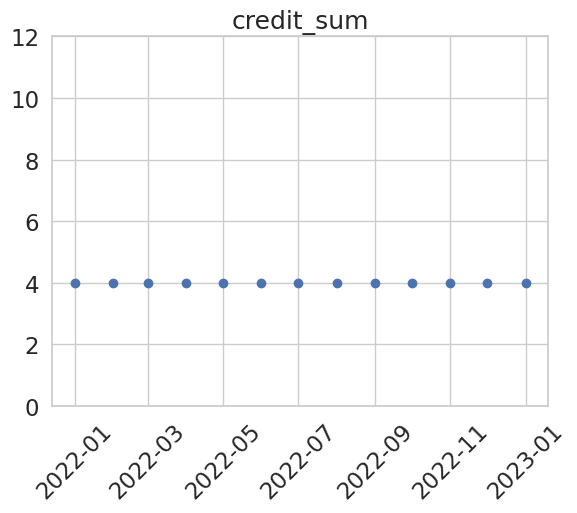

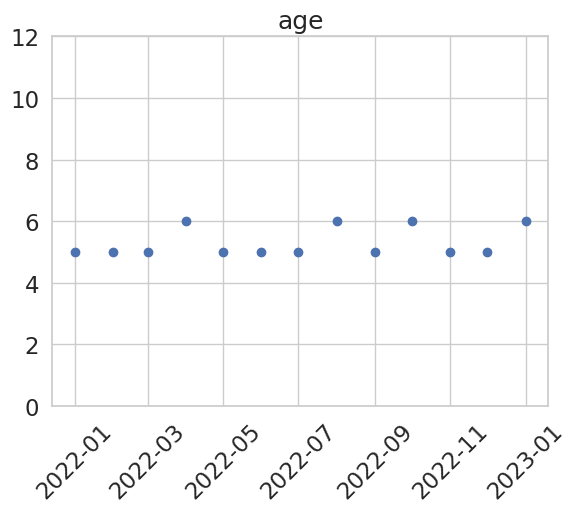

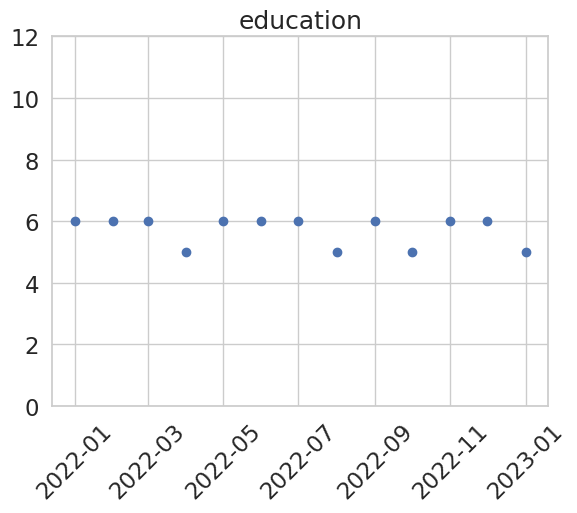

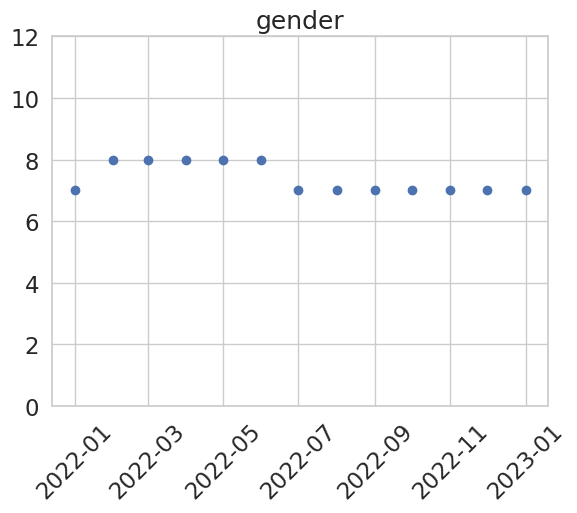

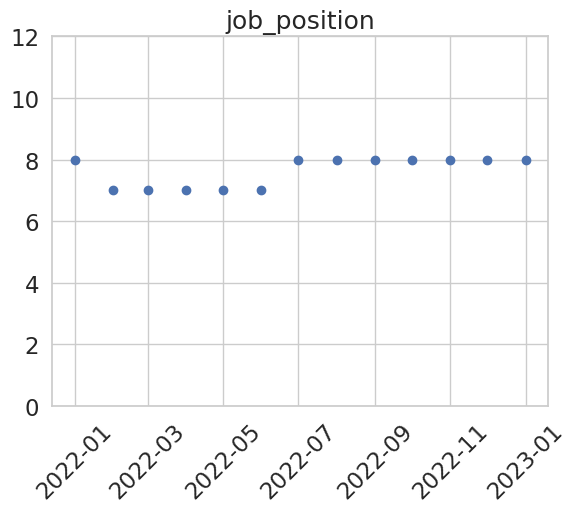

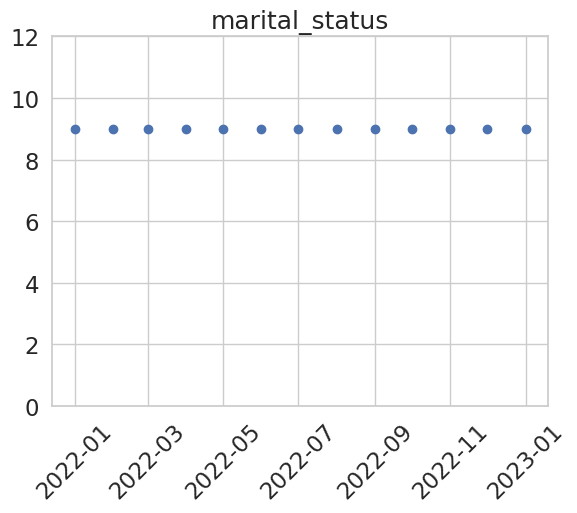

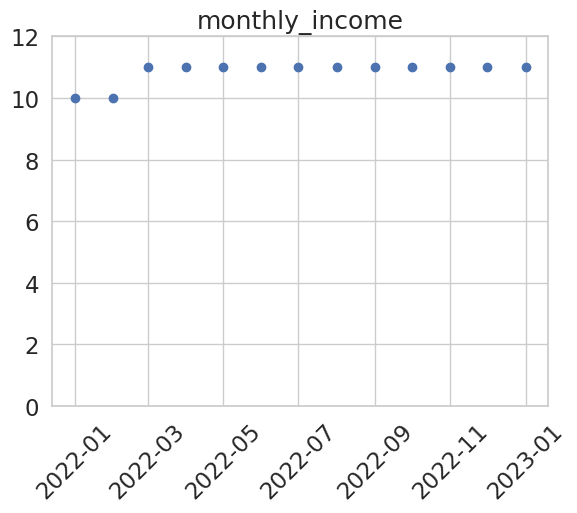

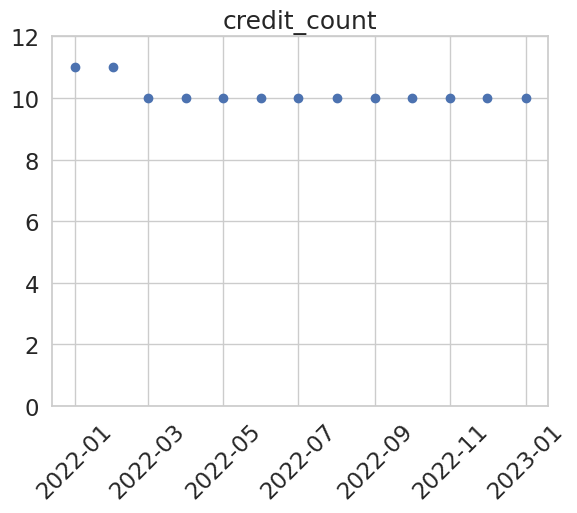

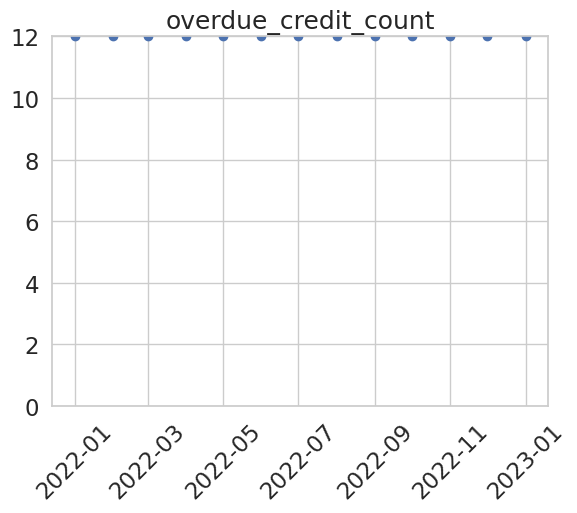

In [ ]:
import matplotlib.pyplot as plt
def plot_fi(df):
  for row in df.iterrows():
    plt.scatter(x = row[1].index, y = row[1])
    plt.gca().tick_params(axis='x', rotation=45)
    plt.ylim(0, 12)
    plt.gca().set_title(label = row[0])
    plt.show()

plot_fi(res)

## 2. GNN для скоринга
## из соревнования с нашего курса по GNN  https://www.kaggle.com/t/345c5ca4c78742039e00559b3fbbbf12


In [ ]:
!pip install pyarrow -q

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html -q
!pip install git+https://github.com/pyg-team/pytorch_geometric.git -q

2.5.1+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd

In [ ]:
import torch
print(torch.cuda.is_available())
import torch_geometric

torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.use_deterministic_algorithms(mode=True)

True


In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget -q "https://drive.usercontent.google.com/download?id=14JSxA8wykthwvNe_2HgKHsJnBFl9776c&export=download&confirm=t" -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
  inflating: df_edges.parquet        
  inflating: df_nodes.parquet        
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%time
df_edges = pd.read_parquet('df_edges.parquet')
df_nodes = pd.read_parquet('df_nodes.parquet')

CPU times: user 17.9 s, sys: 5.68 s, total: 23.6 s
Wall time: 14.3 s


In [ ]:
df_nodes.head(2)

node_feature_1  node_feature_2  node_feature_3  node_feature_4  \
0             1.0             1.0             1.0             1.0   
1             0.0             NaN             1.0             NaN   

   node_feature_5  node_feature_6  node_feature_7  node_feature_8  \
0             1.0             1.0             1.0             1.0   
1             1.0             NaN             1.0             NaN   

   node_feature_9  node_feature_10  ...  node_feature_237  node_feature_238  \
0             1.0              0.0  ...               NaN               NaN   
1             NaN              1.0  ...          1.753344          2.027835   

   node_feature_239  node_feature_240  node_feature_241  node_feature_242  \
0               NaN               NaN               NaN               NaN   
1               0.0               0.0               0.0               0.0   

   node_feature_243  node_feature_244  node_feature_245  index  
0               NaN               NaN               NaN      0  
1               0.0          0.429199               0.0      1  

[2 rows x 246 columns]

In [ ]:
node_group_col = 'node_feature_1'
del df_nodes['index']

In [ ]:
a = df_nodes.isnull()#.sum(axis=0)

b = a[df_nodes[node_group_col]==0].sum(axis=0)
features_group0 = b[b==0].index.tolist()
features_group0.remove(node_group_col)

b = a[df_nodes[node_group_col]==1].sum(axis=0)
features_group1 = b[b==0].index.tolist()
features_group1.remove(node_group_col)

del a

In [ ]:
print("Число фичей для группы вершин 0:",len(features_group0))
print("Число фичей для группы вершин 1:",len(features_group1))

Число фичей для группы вершин 0: 134
Число фичей для группы вершин 1: 162


In [ ]:
# Найдем индексы этих фичей
cols = df_nodes.columns.tolist()
features_idx_group0 = [cols.index(c) for c in features_group0]
features_idx_group1 = [cols.index(c) for c in features_group1]
df_edges.head(2)

edge_feature_1  edge_feature_2  edge_feature_3  edge_feature_5  \
0             1.0             1.0       -1.489233       -2.149860   
1             1.0             1.0        0.756959        0.831242   

   edge_feature_7  edge_feature_9  edge_feature_11  edge_feature_12  \
0        0.874358        -2.07540         -0.81038         1.519856   
1       -0.422108         0.88719         -0.81038         0.233813   

   edge_feature_13  edge_feature_14  ...  edge_feature_41  edge_feature_42  \
0         0.744896        -0.484251  ...         0.133585         0.000000   
1         0.744896         0.829714  ...         0.506228         0.299537   

   edge_feature_43  edge_feature_44  edge_feature_45  edge_feature_46  \
0         0.000000         0.000000         0.153324         0.000000   
1         0.928534         0.909701         0.969412         0.772556   

   edge_feature_47  edge_feature_48  index1  index2  
0              0.0              0.0   14995       0  
1              0.0              0.0   14996       0  

[2 rows x 46 columns]

In [ ]:
x = torch.FloatTensor(df_nodes.values)
edge_index = torch.LongTensor(df_edges[['index1','index2']].values).T

del df_edges['index1']
del df_edges['index2']

edge_attr = torch.FloatTensor(df_edges.values)
from torch_geometric.data import Data

### Таргет

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# 4 бинарных таргета
# доли 1 в каждом тарегте, число 1, размер выборки по таргету
df_train.groupby('label_type').y.agg(['mean','sum','count'])

mean  sum  count
label_type                      
label_3     0.247525   75    303
label_4     0.171748  338   1968
label_5     0.208788  708   3391
label_6     0.088658  401   4523

In [ ]:
# размер выборки по таргету для test
df_test.label_type.value_counts()

label_type
label_6    2229
label_5    1671
label_4     969
label_3     149
Name: count, dtype: int64

In [ ]:
df_y = df_train.pivot(columns='label_type',index='index',values='y')
df_y.head()

label_type  label_3  label_4  label_5  label_6
index                                         
2               NaN      NaN      0.0      NaN
3               NaN      NaN      0.0      NaN
4               NaN      0.0      NaN      NaN
5               NaN      0.0      NaN      NaN
9               NaN      NaN      NaN      0.0

In [ ]:
df_y_ = pd.DataFrame(np.arange(len(x)) , columns=['index'])
df_y = df_y_.merge(df_y.reset_index(), on='index',how='left').set_index('index')
df_y.head()

label_3  label_4  label_5  label_6
index                                    
0          NaN      NaN      NaN      NaN
1          NaN      NaN      NaN      NaN
2          NaN      NaN      0.0      NaN
3          NaN      NaN      0.0      NaN
4          NaN      0.0      NaN      NaN

In [ ]:
df_y['has_target'] = df_y.notnull().sum(axis=1) > 0
df_y = df_y.fillna(-100)
df_y.head(1)

label_3  label_4  label_5  label_6  has_target
index                                                
0       -100.0   -100.0   -100.0   -100.0       False

In [ ]:
node_type = torch.ShortTensor(df_nodes[node_group_col].values)

### Data

In [ ]:
# 4 таргета
label_3 = torch.LongTensor(df_y.label_3.values)
label_4 = torch.LongTensor(df_y.label_4.values)
label_5 = torch.LongTensor(df_y.label_5.values)
label_6 = torch.LongTensor(df_y.label_6.values)

#
has_target = torch.BoolTensor(df_y.has_target.values)

In [ ]:
data = Data(x=x, # node features
            edge_index=edge_index, # edges
            edge_attr=edge_attr, # edge attributes
            label_3=label_3,
            label_4=label_4,
            label_5=label_5,
            label_6=label_6,
            has_target=has_target,# whether node has target
            node_type=node_type, # 0 or 1st type of node
            index = torch.arange(len(x))# unique identifier of node
           )

In [ ]:
print('===================================')

print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Number of features: {data.x.shape[1]}')

if data.edge_attr is not None:
    print(f'Number of edge attributes: {data.edge_attr.shape[1]}')


print(f'Number of nodes with target: {int(data.has_target.sum())}')
print('===================================')

Number of nodes: 3345036
Number of edges: 3907086
Number of features: 245
Number of edge attributes: 44
Number of nodes with target: 10046


### Локальная валидация

In [ ]:
from sklearn.model_selection import train_test_split
stratify = df_y[df_y['has_target']].drop('has_target',axis=1).max(axis=1)
train_index, valid_index = train_test_split(torch.nonzero(data.has_target)[:,0],
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=stratify,
                                            random_state=402)
test_index = df_test['index'].unique()
len(train_index), len(valid_index), len(test_index)

(8036, 2010, 4949)

In [ ]:
from torch_geometric.loader import NeighborLoader
batch_size = 200

loader_train = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=train_index,
)

loader_valid = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=valid_index,
)


loader_test = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=test_index,
)

loader_train = [c for c in tqdm.tqdm(loader_train)]
loader_valid = [c for c in tqdm.tqdm(loader_valid)]
loader_test = [c for c in tqdm.tqdm(loader_test)]

100%|██████████| 25/25 [00:02<00:00, 10.58it/s]


### Модель

In [ ]:
from torch.nn import Linear, ReLU, Sequential, Identity, Dropout, PReLU, Tanh, ELU, LeakyReLU, Sigmoid, GELU
from torch_geometric.nn import GraphConv, SAGEConv

In [ ]:
class GeneralGNN(torch.nn.Module):
    def __init__(self,
                 Act = ReLU,
                 ConvClass = GraphConv,
                 hidden_size1 = 256,
                 conv1_aggrs = {'mean':128, 'max':64, 'add':32},
                 conv2_aggrs = {'mean': 64, 'max':16, 'add':8},
                 dropout_rate = 0.25,
                 target_names = ['label_3','label_4','label_5','label_6'],
                 features_idx_group0 = features_idx_group0,
                 features_idx_group1 = features_idx_group1,
                ):
        super(GeneralGNN, self).__init__()
        torch.manual_seed(420)

        self.hidden_size1 = hidden_size1
        self.target_names = target_names
        self.features_idx_group0 = features_idx_group0
        self.features_idx_group1 = features_idx_group1


        # preprocces node featrues, reduce to a common dimension
        self.lin_preproc = torch.nn.ModuleList(
            modules = [
                Linear(len(features_idx_group0), hidden_size1),
                Linear(len(features_idx_group1), hidden_size1)
            ]
        )
        self.activation = Act()
        self.dropout = Dropout(dropout_rate)


        # 1-level convolution with different aggregate functions
        input_size = hidden_size1

        self.conv1 = torch.nn.ModuleDict()
        for aggr, output_size in conv1_aggrs.items():
            self.conv1[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv1_activation = Act()
        self.conv1_dropout = Dropout(dropout_rate)


        # 2-level convolution with different aggregate functions
        input_size = sum(conv1_aggrs.values())

        self.conv2 = torch.nn.ModuleDict()
        for aggr, output_size in conv2_aggrs.items():
            self.conv2[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv2_activation = Act()
        self.conv2_dropout = Dropout(dropout_rate)
        # MAKE PREDICTION FOR EACH TASK
        input_size = sum(conv2_aggrs.values())
        self.lin_out = torch.nn.ModuleDict()
        for name in self.target_names:
            self.lin_out[name] = Linear(input_size, 2)


    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        node_type = data.node_type

        # preprocces node featrues, reduce to a common dimension
        x_out = torch.zeros(len(x), self.hidden_size1, device=x.device)

        x_out[node_type==0] = self.lin_preproc[0](x[node_type==0][:,self.features_idx_group0])
        x_out[node_type==1] = self.lin_preproc[1](x[node_type==1][:,self.features_idx_group1])

        x = self.dropout(self.activation(x_out))

        # concatencate outputs of 1-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv1.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv1_dropout(self.conv1_activation(x))

        # concatencate outputs of 2-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv2.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv2_dropout(self.conv2_activation(x))

        outs = {name: self.lin_out[name](x) for name in self.target_names}

        return outs

In [ ]:
model = GeneralGNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GeneralGNN(
  (lin_preproc): ModuleList(
    (0): Linear(in_features=134, out_features=256, bias=True)
    (1): Linear(in_features=162, out_features=256, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (conv1): ModuleDict(
    (mean): GraphConv(256, 128)
    (max): GraphConv(256, 64)
    (add): GraphConv(256, 32)
  )
  (conv1_activation): ReLU()
  (conv1_dropout): Dropout(p=0.25, inplace=False)
  (conv2): ModuleDict(
    (mean): GraphConv(224, 64)
    (max): GraphConv(224, 16)
    (add): GraphConv(224, 8)
  )
  (conv2_activation): ReLU()
  (conv2_dropout): Dropout(p=0.25, inplace=False)
  (lin_out): ModuleDict(
    (label_3): Linear(in_features=88, out_features=2, bias=True)
    (label_4): Linear(in_features=88, out_features=2, bias=True)
    (label_5): Linear(in_features=88, out_features=2, bias=True)
    (label_6): Linear(in_features=88, out_features=2, bias=True)
  )
)

In [ ]:
def train_epoch(model, loader, device, optimizer, scheduler, tqdm_disable=True):
    """
    учим модель одну эпоху
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = sampled_data.clone().to(device)
        sampled_data.has_target[sampled_data.batch_size:] = False

        optimizer.zero_grad()
        outs = model(sampled_data)
        loss = get_train_loss(sampled_data, outs)
#         loss = F.nll_loss(out[sampled_data.label_mask], sampled_data.y[sampled_data.label_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    scheduler.step()

    calc_time = time.time() - start_time
    return total_loss, calc_time

In [ ]:
def get_train_loss(sampled_data, outs):
    ys = {name: getattr(sampled_data,name)[:sampled_data.batch_size] for name in target_names}
    outs = {name: outs[name][:sampled_data.batch_size] for name in target_names}
    loss = 0
    for name in target_names:
        y = ys[name]
        out = outs[name]
        l = criterion(out,y)
        if not torch.isnan(l):
            loss +=l
    return loss/batch_size

In [ ]:
def eval_model(model, loader, device, tqdm_disable=True):
    """
    get prediction


    """
    start_time = time.time()
    softmax = torch.nn.Softmax(dim=1)

    dfs = []

    model.eval()
    with torch.no_grad():

        for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = sampled_data.clone().to(device)
            outs = model(sampled_data)
            outs = {name: softmax(
                                outs[name][:sampled_data.batch_size].detach()
                            )[:,1].cpu().numpy() for name in target_names
                   }
            outs['index'] = sampled_data.index[:sampled_data.batch_size].cpu().numpy()
            dfs.append(pd.DataFrame(outs))

    result = pd.concat(dfs,axis=0)

    df_score = pd.melt(result, id_vars=['index'], value_vars=target_names).rename(
    columns={'variable':'label_type','value':'score'})
    return df_score

In [ ]:
from sklearn.metrics import roc_auc_score
def cacl_auc(df_score, df_truth):
    df = df_truth.merge(df_score, on=['index','label_type'])
    return roc_auc_score(df.y, df.score) #, df.shape[0]

In [ ]:
target_names = ['label_3','label_4','label_5','label_6']

In [ ]:
# там где таргет -100 лосс не считаем
criterion = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100, label_smoothing = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
      optimizer = optimizer,
      milestones = [10, 20, 40],
      gamma = 0.1)

### Train

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [ ]:
for epoch in range(10):
    total_loss, calc_time = train_epoch(model, loader_train, device, optimizer, scheduler, tqdm_disable=False)

    df_score = eval_model(model, loader_train, device, tqdm_disable=True)
    train_auc = cacl_auc(df_score, df_train)

    df_score = eval_model(model, loader_valid, device, tqdm_disable=True)
    valid_auc = cacl_auc(df_score, df_train)

    print(f'Epoch:{epoch:03d} TrainLoss : {total_loss:.3f}, Train AUC : {train_auc:.3f}, VALID AUC : {valid_auc:.3f}',
          file=sys.stderr)

Epoch:000 TrainLoss : 0.883, Train AUC : 0.718, VALID AUC : 0.733
Epoch:001 TrainLoss : 0.394, Train AUC : 0.739, VALID AUC : 0.737
Epoch:002 TrainLoss : 0.383, Train AUC : 0.776, VALID AUC : 0.752
Epoch:003 TrainLoss : 0.376, Train AUC : 0.787, VALID AUC : 0.770
Epoch:004 TrainLoss : 0.374, Train AUC : 0.791, VALID AUC : 0.761
Epoch:005 TrainLoss : 0.372, Train AUC : 0.795, VALID AUC : 0.753
Epoch:006 TrainLoss : 0.362, Train AUC : 0.803, VALID AUC : 0.766
Epoch:007 TrainLoss : 0.362, Train AUC : 0.809, VALID AUC : 0.756
Epoch:008 TrainLoss : 0.363, Train AUC : 0.813, VALID AUC : 0.756
Epoch:009 TrainLoss : 0.366, Train AUC : 0.809, VALID AUC : 0.761


In [ ]:
df_score = eval_model(model, loader_valid, device, tqdm_disable=True)
print('GNN ROC AUC : {:.3f}'.format(cacl_auc(df_score, df_train)))

GNN ROC AUC : 0.761


In [ ]:
df_score_gnn = df_score.rename(columns={'score':'score_gnn'})

### Объединим с бустингом

In [ ]:
df_nodes['split'] = 'none'
df_nodes.loc[train_index,'split'] = 'train'
df_nodes.loc[valid_index,'split'] = 'valid'
df_nodes.loc[test_index,'split'] = 'test'

df_nodes['index'] = np.arange(len(df_nodes))
df_nodes['node_type'] = node_type
df_nodes['has_target'] = has_target
df_dateset = df_nodes.query('has_target==1')


In [ ]:
df_dateset['split'].value_counts()

split
train    8036
valid    2010
Name: count, dtype: int64

In [ ]:
df_dateset = df_dateset.merge(df_train,on=['index'])

In [ ]:
# Тип таргета добавим как фичу
df_dateset['label_int'] = df_dateset['label_type'].map(lambda x: int(x.split('_')[1]))

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# Для кадого типа вершин обучим свой бустинг, потому что набор фичей у них разный
def fit_lgb_and_return_valid_scores(df_dateset, node_type):
  if node_type==0:
    features = features_group0 + ['label_int']
  elif node_type==1:
    features = features_group1 + ['label_int']
  df = df_dateset.query('node_type==@node_type')

  df_train = df.query('split=="train"')
  X_train, y_train = df_train[features], df_train['y']
  df_valid = df.query('split=="valid"')
  X_valid, y_valid = df_valid[features], df_valid['y']

  model = LGBMClassifier(**{'colsample_bytree': 0.8,
  'learning_rate': 0.09,
  'max_depth': 9,
  'n_estimators': 25,
  'min_child_samples':128,
  'num_leaves': 63,
  'reg_alpha': 0,
  'reg_lambda': 100,
  'subsample': 1}, n_jobs=4,verbose=-1)
  model.fit(X_train,y_train)
  y_pred = model.predict_proba(X_valid)[:,1]
  # print(X_train.shape,X_valid.shape)
  # print(y_valid.shape,y_pred.shape)
  # print(roc_auc_score(y_valid,y_pred))
  df_score = df_valid[['index','label_type']]
  df_score['score'] = y_pred
  return df_score

In [ ]:
# Получаем скоры 2 LGB
df_score = pd.concat([fit_lgb_and_return_valid_scores(df_dateset,0),
                      fit_lgb_and_return_valid_scores(df_dateset,1),],axis=0)

In [ ]:
df_score.head(2)

index label_type     score
4       9    label_6  0.081120
10     18    label_5  0.171301

In [ ]:
print('LGB ROC AUC : {:.3f}'.format(cacl_auc(df_score, df_train)))

LGB ROC AUC : 0.742


In [ ]:
# GNN ROC AUC : 0.759
# GNN несколько лучший скор дает

In [ ]:
df_score_lgb = df_score.rename(columns={'score':'score_lgb'})

In [ ]:
df_score = df_score_lgb.merge(df_score_gnn,on=['index','label_type'])

In [ ]:
# усредним скоры -- пока не как на лекциий
df_score['score'] = 0.5 * df_score['score_lgb'] + 0.5 * df_score['score_gnn']

In [ ]:
print('Bagging ROC AUC : {:.3f}'.format(cacl_auc(df_score, df_train)))

Bagging ROC AUC : 0.766


Комбинация алгоритмов дает итоговый лучший скор

### Откалибруемся

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.frozen import FrozenEstimator

def fit_lgb_and_return_valid_calib_scores(df_dateset, node_type):
  if node_type==0:
    features = features_group0 + ['label_int']
  elif node_type==1:
    features = features_group1 + ['label_int']
  df = df_dateset.query('node_type==@node_type')

  df_train = df.query('split=="train"')
  X_train, y_train = df_train[features], df_train['y']
  df_valid = df.query('split=="valid"')
  X_valid, y_valid = df_valid[features], df_valid['y']

  model = LGBMClassifier(**{'colsample_bytree': 0.8,
  'learning_rate': 0.09,
  'max_depth': 9,
  'n_estimators': 25,
  'min_child_samples':128,
  'num_leaves': 63,
  'reg_alpha': 0,
  'reg_lambda': 100,
  'subsample': 1}, n_jobs=4,verbose=-1)

  model.fit(X_train,y_train)
  y_pred = model.predict_proba(X_valid)[:,1]

  calibrated_classifier = CalibratedClassifierCV(
      estimator=FrozenEstimator(model), method='isotonic', cv=2
  ).fit(X_train, y_train)

  prob_pos_clf = model.predict_proba(X_valid)[:, 1]
  clf_score = brier_score_loss(y_valid, prob_pos_clf)
  print(f"No calibration: {clf_score:.3f}")

  prob_pos_calibrated = calibrated_classifier.predict_proba(X_valid)[:, 1]
  calibrated_score = brier_score_loss(y_valid, prob_pos_calibrated)
  print(f"With calibration: {calibrated_score:.3f}")


  # print(X_train.shape,X_valid.shape)
  # print(y_valid.shape,y_pred.shape)
  # print(roc_auc_score(y_valid,y_pred))
  df_score = df_valid[['index','label_type']]
  df_score['score'] = prob_pos_calibrated
  return df_score


In [ ]:
# Получаем скоры 2 LGB
df_score_calibrated = pd.concat([fit_lgb_and_return_valid_calib_scores(df_dateset,0),
                      fit_lgb_and_return_valid_calib_scores(df_dateset,1),],axis=0)

No calibration: 0.116
With calibration: 0.117
No calibration: 0.119
With calibration: 0.120


#### Раз калибровка и так хорошая -- не будем портить?

Для самых дотошных -- попробуйте Venn-Abers

https://www.kaggle.com/code/carlmcbrideellis/classifier-calibration-using-venn-abers

In [ ]:
print('LGB ROC AUC : {:.3f}'.format(cacl_auc(df_score_calibrated, df_train)))

LGB ROC AUC : 0.741


Даже чуть качество уровнили!

In [ ]:
df_score_calibrated_lgb = df_score_calibrated.rename(columns={'score':'score_lgb'})

In [ ]:
df_score_calibrated = df_score_calibrated_lgb.merge(df_score_gnn,on=['index','label_type'])

In [ ]:
df_score_calibrated

index label_type  score_lgb  score_gnn
0         9    label_6   0.026627   0.024504
1        18    label_5   0.235154   0.370690
2        22    label_6   0.049645   0.057089
3        24    label_6   0.016713   0.007825
4        26    label_4   0.103896   0.159600
...     ...        ...        ...        ...
2034  14939    label_6   0.149254   0.022123
2035  14951    label_5   0.042929   0.054943
2036  14960    label_5   0.769231   0.512473
2037  14961    label_6   0.042929   0.029562
2038  14974    label_4   0.642202   0.295581

[2039 rows x 4 columns]

In [ ]:
# усредним скоры -- снова не как на лекциий
df_score_calibrated['score'] = 0.5 * df_score_calibrated['score_lgb'] + 0.5 * df_score_calibrated['score_gnn']

In [ ]:
print('Bagging ROC AUC : {:.3f}'.format(cacl_auc(df_score_calibrated, df_train)))

Bagging ROC AUC : 0.762


Итоговый скор тоже уронили немного!

### Проверим -- мб простого осреднения было достаточно?

In [ ]:
def log_odds(pd):
  return np.log(pd / (1 - pd))

In [ ]:
df_big = df_train.merge(df_score, on=['index','label_type']).copy()
df_big.head()

task_id  index label_type  y  score_lgb  score_gnn     score
0        4      4    label_4  0   0.079410   0.054985  0.067197
1        9      9    label_6  0   0.081120   0.024504  0.052812
2       17     17    label_4  1   0.102054   0.174066  0.138060
3       18     18    label_5  1   0.171301   0.370690  0.270996
4       22     22    label_6  0   0.099632   0.057089  0.078360

In [ ]:
df_big['odds_score_lgb'] = log_odds(df_big['score_lgb'])
df_big['odds_score_gnn'] = log_odds(df_big['score_gnn'])

Train / test split

In [ ]:
## sample
np.random.seed(45)
mask = np.random.choice([True, False], size=(len(df_big['y']),), p=[1./4, 3./4])

In [ ]:
un_train = df_big[['odds_score_lgb', 'odds_score_gnn', 'y']][mask]
un_test = df_big[['odds_score_lgb', 'odds_score_gnn', 'y']][~mask]

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0).fit(un_train.drop('y', axis = 1), un_train['y'])
y_pred = clf.predict_proba(un_test.drop('y', axis = 1))[:,1]

In [ ]:
roc_auc_score(un_test['y'], y_pred)

0.7650710043893624

Усреднение скоров давало 0.766 😒

In [ ]:
roc_auc_score(df_big['y'], clf.predict_proba(df_big[['odds_score_lgb', 'odds_score_gnn']])[:,1])

0.7644130138025178

Вывод -- всегда смотрите на метрики!